In [112]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

In [125]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        #if not np.isnan(data[i,j,-1]):
        if not data[i,j,-1]<0:    
            result.append(data[i,j,:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [35]:
from sklearn.manifold import TSNE, MDS, Isomap

In [99]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])

In [101]:
TSNE(n_components=2).fit(X)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

In [72]:
X_embedded = TSNE(n_components=2,perplexity=80.0).fit_transform(np.transpose(result))

In [93]:
#mds = manifold.MDS(n_components, max_iter=100, n_init=1)
X_embedded = MDS(n_components =3, max_iter=1000, n_init=1).fit_transform(np.transpose(result))

In [57]:
X_embedded  = Isomap(n_neighbors =10, n_components=2).fit_transform(np.transpose(result))

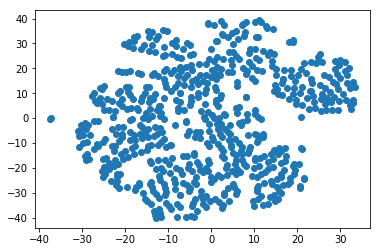

In [88]:
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
plt.scatter(vis_x, vis_y)
#plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [76]:
from sklearn.cluster import AgglomerativeClustering

In [122]:
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.array(result))

In [123]:
df["clusters"] = clustering.labels_

In [120]:
data.shape

(34, 32, 841)

In [114]:
n_components = 5

#result = np.matrix(result)
#result = result.transpose()
result = pf.deseasonalize(np.transpose(np.array(result)))
data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


#loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
loading = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

Text(0.5,1,'PC 0')

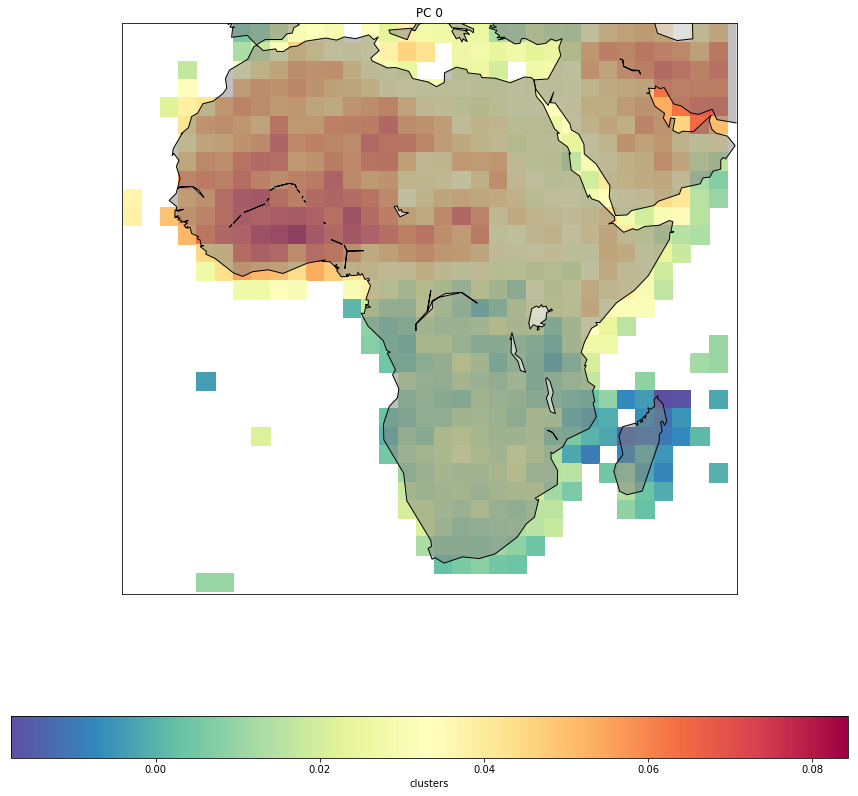

In [46]:
pc = 0
df["pc"] = loading[pc]

lon1 = np.arange(-23.75,60.0,2.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon1[j])].clusters.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon1[j])].pc.values
        else:
            deg[i,j]=np.nan

#deg = np.flip(deg, axis=0)

#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('clusters')
plt.title("PC %d"%(pc))

Text(0.5,1,'PC 0')

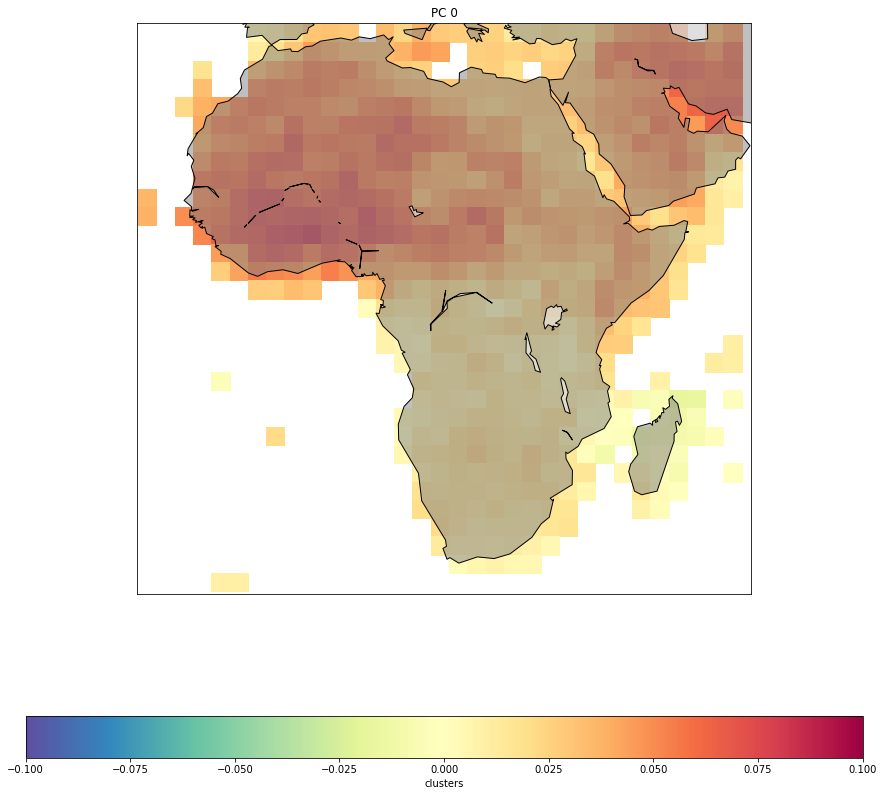

In [131]:
pc = 0
df["pc"] = loading[pc]

lon1 = np.arange(-23.75,60.0,2.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon1[j])].clusters.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon1[j])].pc.values
        else:
            deg[i,j]=np.nan

#deg = np.flip(deg, axis=0)

#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
plt.clim(-0.1,0.1)
cbar.set_label('clusters')
plt.title("PC %d"%(pc))

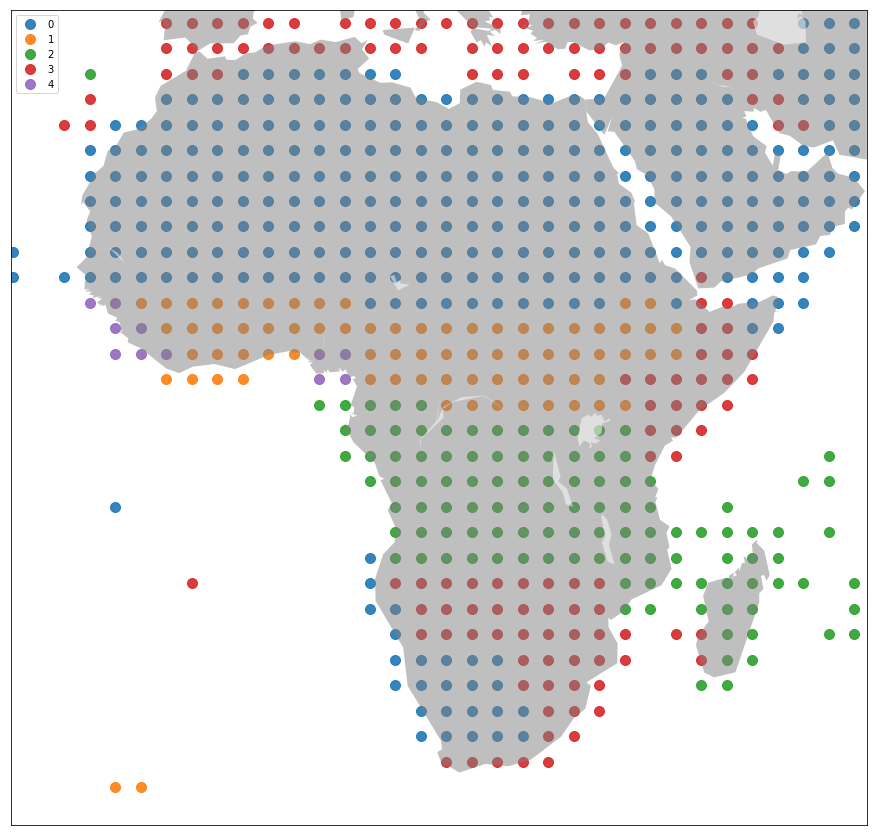

In [124]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)

#colors = pf.random_color_1(n_components)

for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()

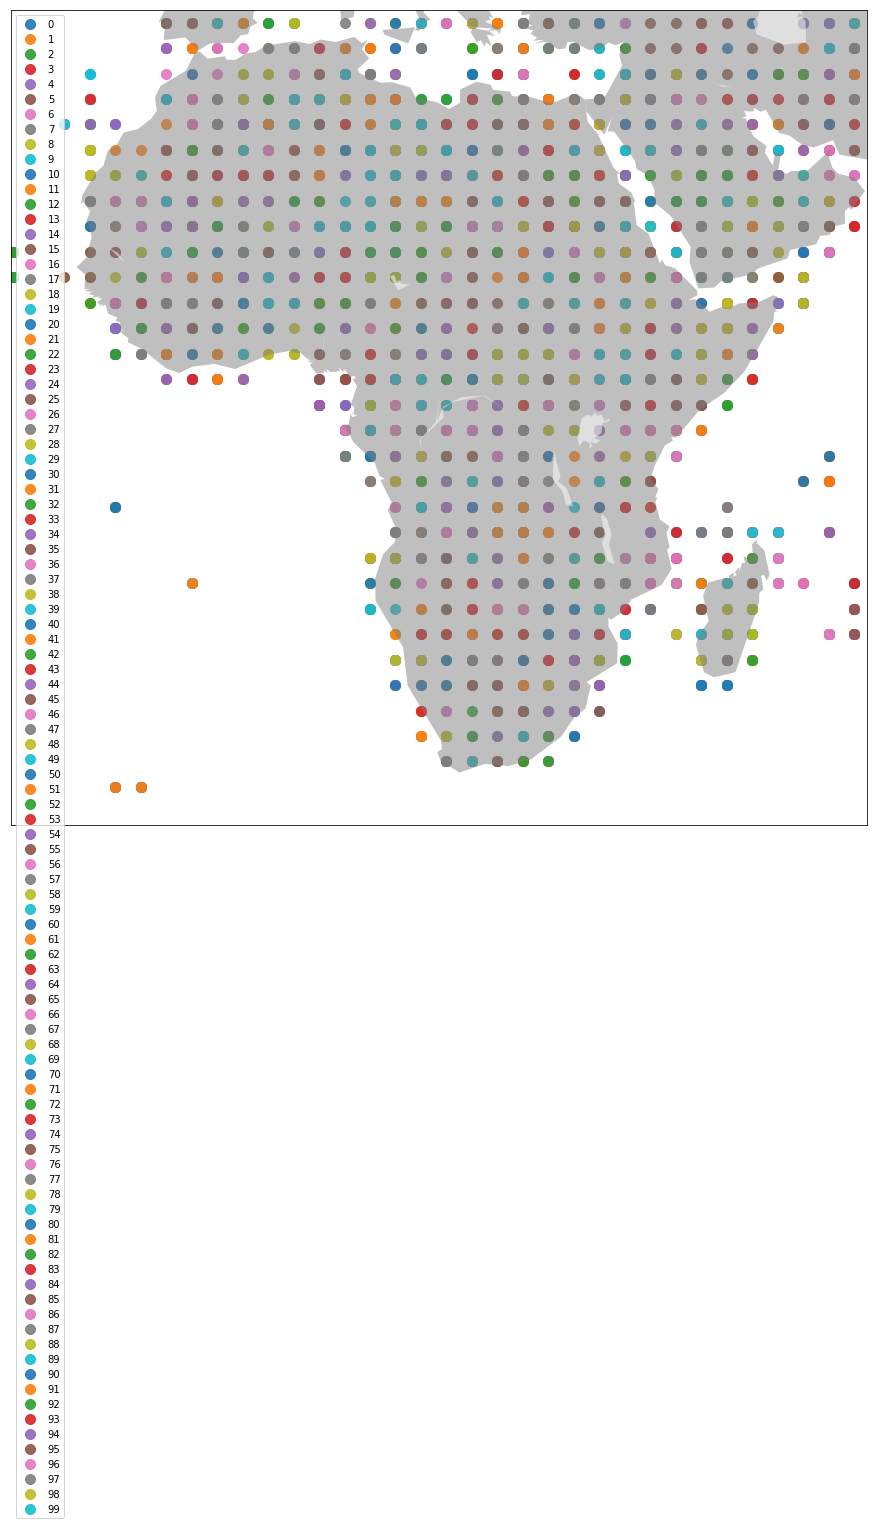

In [62]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)

limit = 0.95

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()

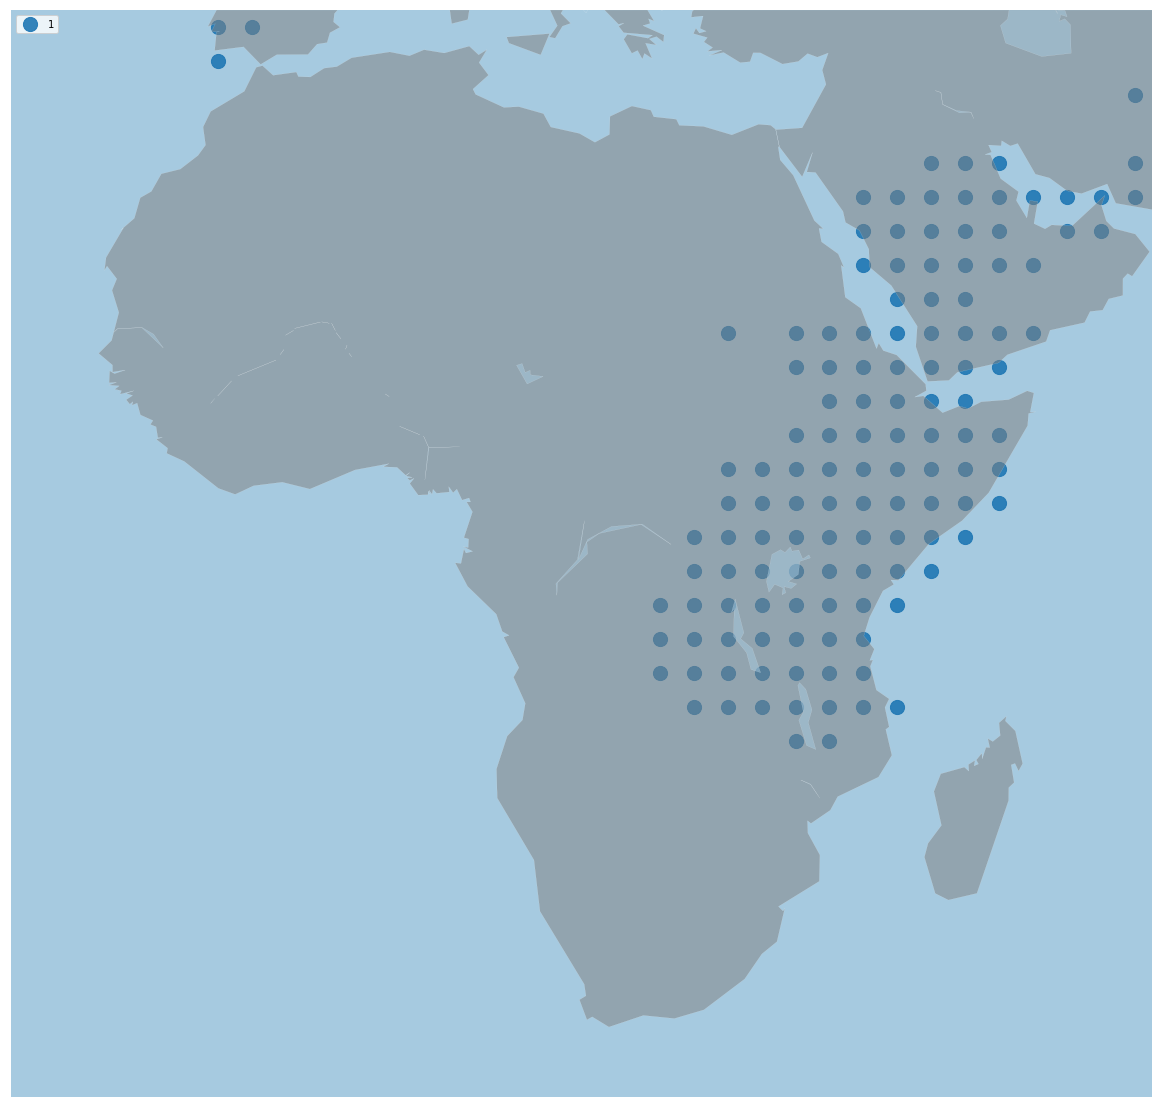

In [62]:
limit = 0.8

i = 1
df1 = pd.DataFrame(columns=df.columns)

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
df1 = df.iloc[Idx,:]
df1["values"] = values

lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [211]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

In [212]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
#results['val_matrix'][0]

In [15]:
#results['p_matrix'][0]

In [213]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val = 0.244
        (1 -1): pval = 0.00958 | val = -0.090
        (4 -1): pval = 0.03339 | val = 0.074

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | val = 0.265
        (0 -2): pval = 0.01539 | val = 0.084

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val = 0.265
        (1 -1): pval = 0.00021 | val = -0.128
        (2 -2): pval = 0.02582 | val = 0.077

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val = 0.192
        (0 -2): pval = 0.00481 | val = 0.098

    Variable 4 has 3 link(s):
        (4 -1): pval = 0.00000 | val = 0.224
        (3 -2): pval = 0.01645 | val = -0.083
        (1 -1): pval = 0.02915 | val = -0.076


In [214]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 1 link(s):
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.244

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.265

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.265
        (1 -1): pval = 0.00021 | qval = 0.00172 | val = -0.128

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.192

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.224


In [215]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ff9dd6470>)

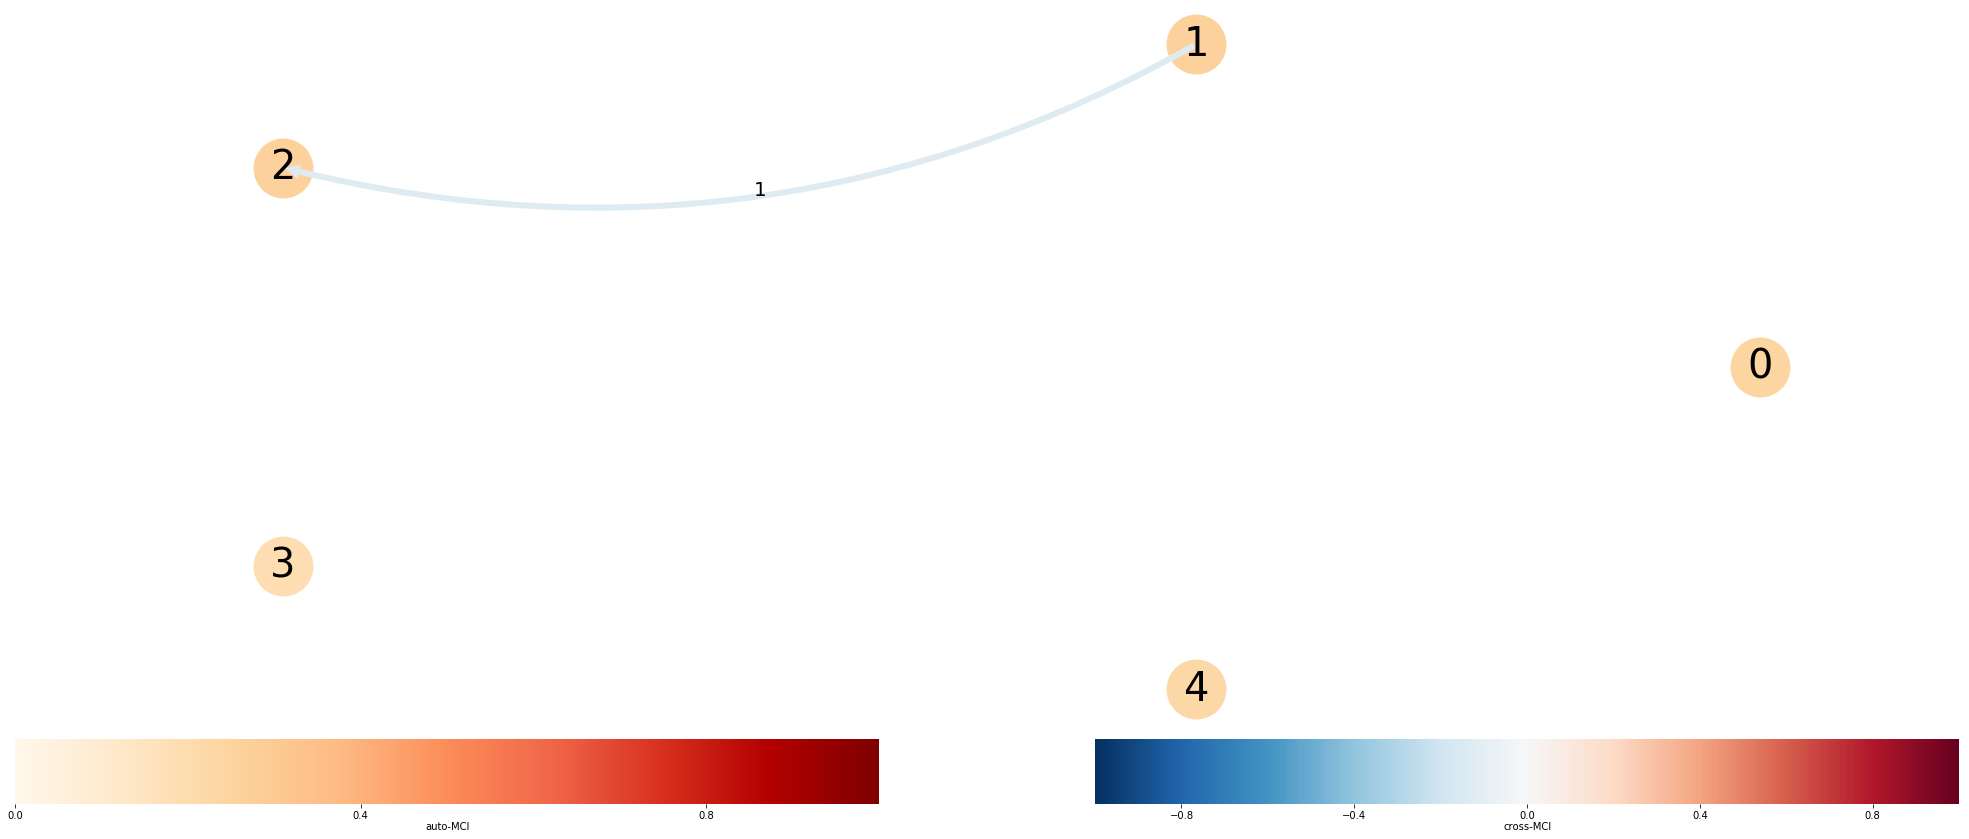

In [216]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

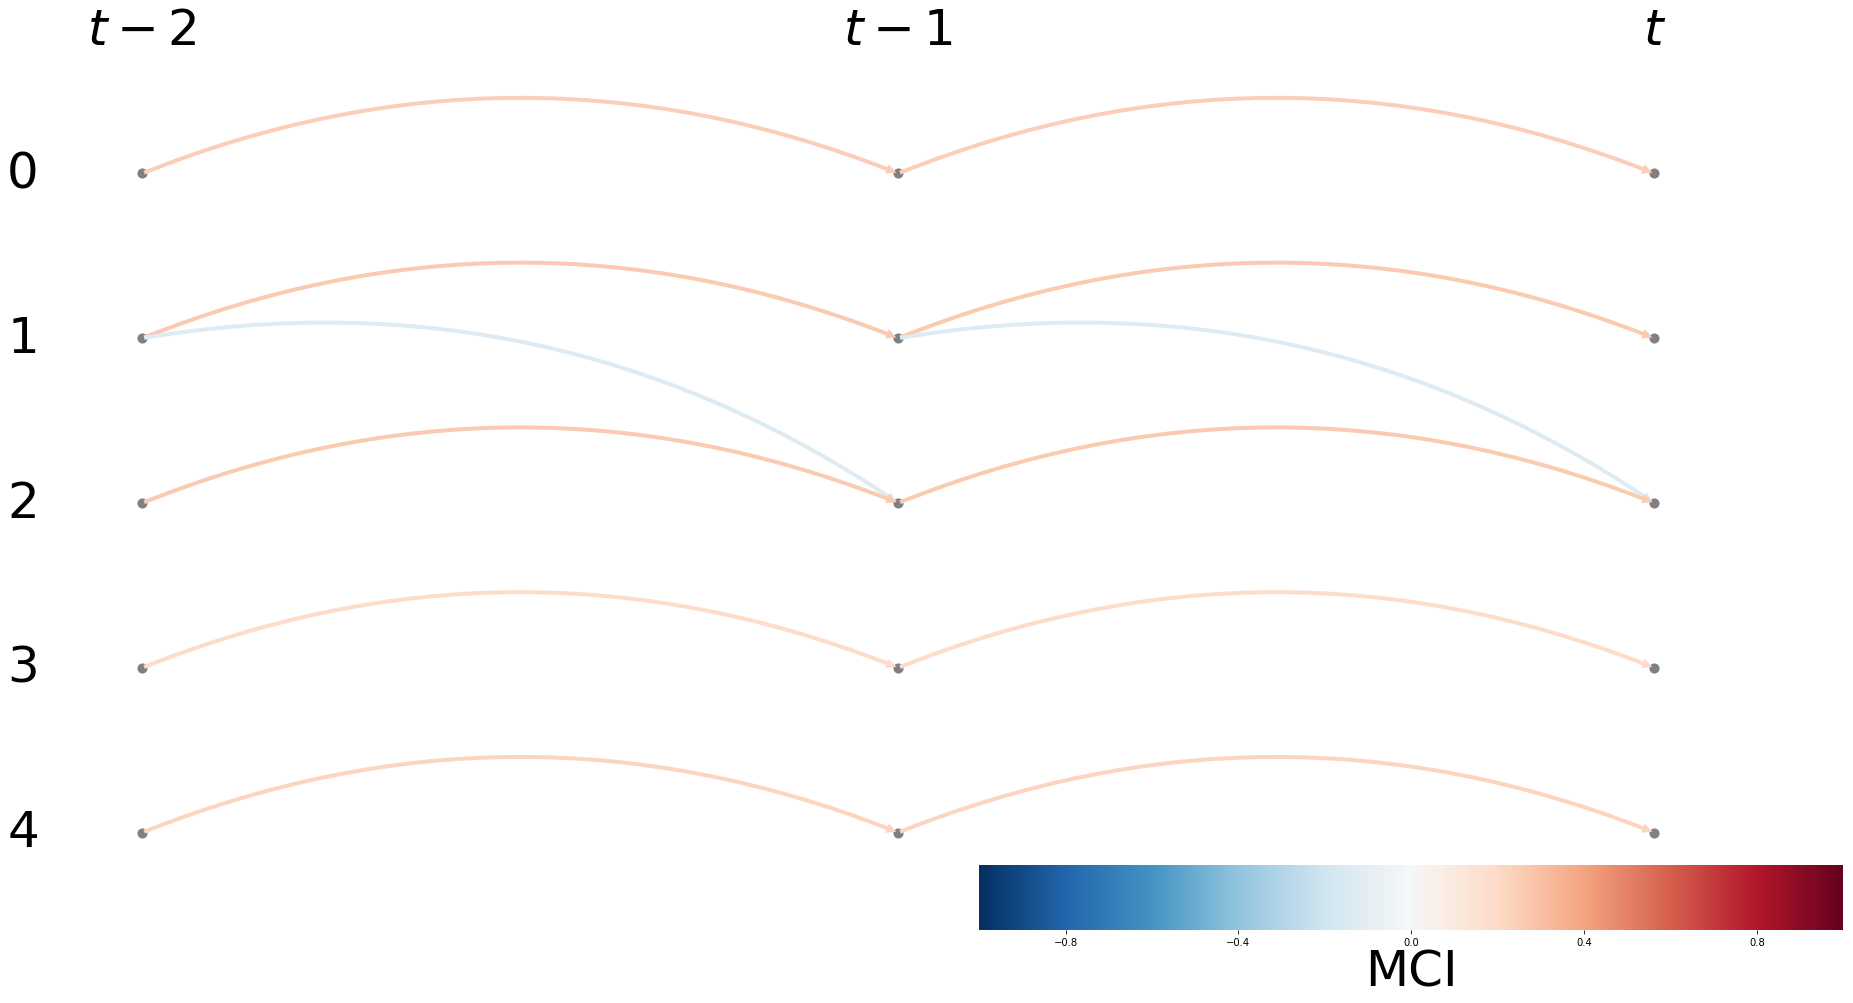

In [217]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

# Half Degree GPCC data

In [11]:
f_pre = Dataset('GPCC_half.nc')
data = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
time = f_pre.variables['time'][:]
data = np.swapaxes(data,0,2)

In [4]:
n_components = 5
level = 12

In [101]:
result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        #if not np.isnan(data[i,j,-1]):
        if not data[i,j,-1]<0:    
            result.append(data[i,j,:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [ ]:
result = pf.deseasonalize(np.transpose(np.array(result)), freq=level)

In [37]:
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

result = pf.deseasonalize(np.array(result), freq=level)

In [32]:
data = pd.DataFrame(result)

In [15]:
pca.explained_variance_ratio_.sum()

0.13137258619173126

In [33]:
#result = np.mat`rix(result)
#result = result.transpose()
#result = pf.deseasonalize(np.transpose(np.array(result)))
#data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)

In [34]:
#loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
loading = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [35]:
pc = 0
df["pc"] = loading[pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1 = np.arange(-29.75,59.75,0.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon1[j])].clusters.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon1[j])].pc.values
        else:
            deg[i,j]=np.nan

#deg = np.flip(deg, axis=0)

Text(0.5,1,'PC 0')

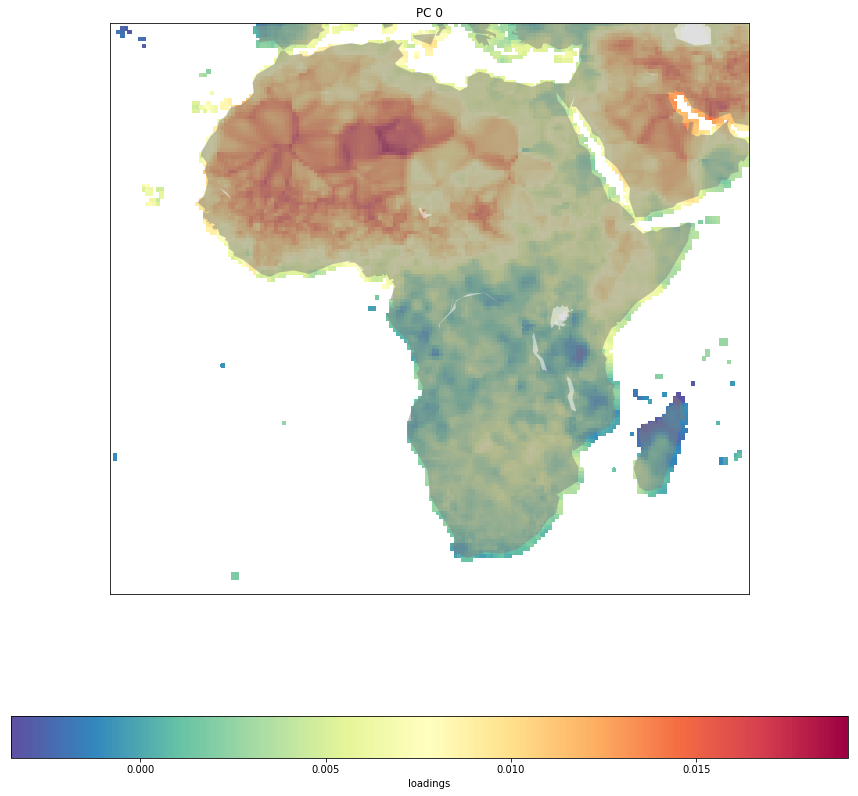

In [14]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('loadings')
plt.title("PC %d"%(pc))

Text(0.5,1,'PC 0')

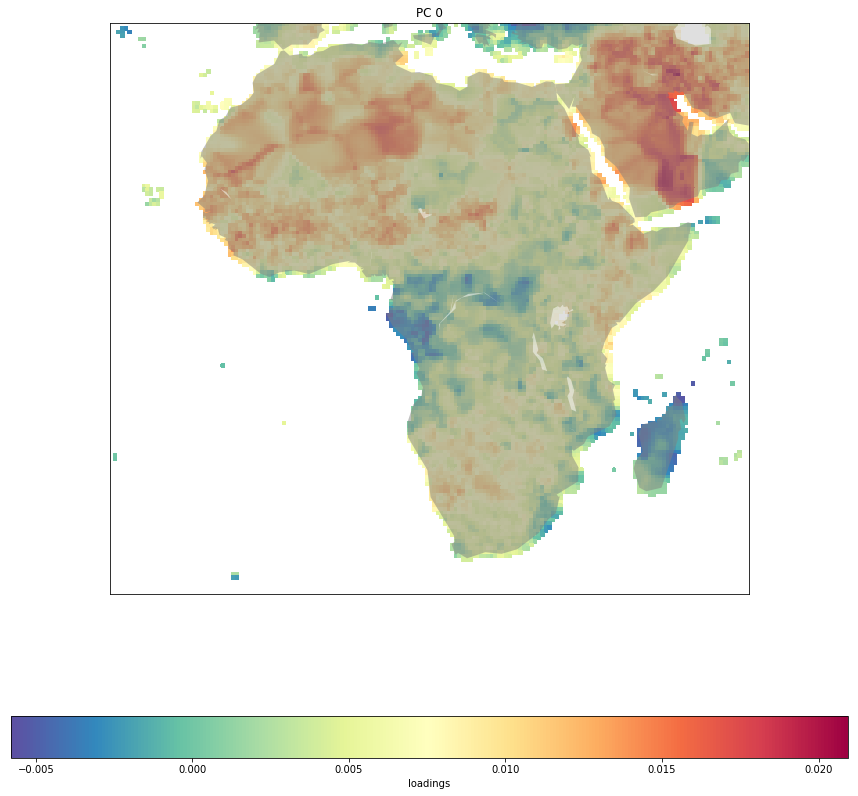

In [36]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('loadings')
plt.title("PC %d"%(pc))

Text(0.5,1,'PC 2')

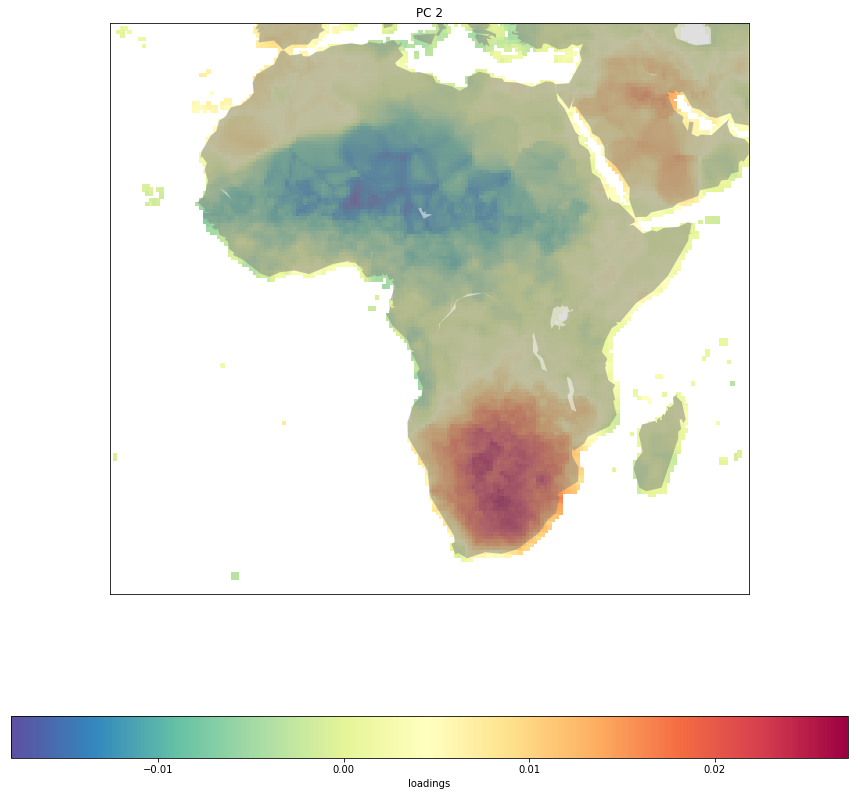

In [21]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('loadings')
plt.title("PC %d"%(pc))

In [51]:
_ecdf(a)

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [47]:
nobs = 4

In [48]:
np.arange(1,nobs+1)/float(nobs)

array([0.25, 0.5 , 0.75, 1.  ])

In [53]:
np.percentile(a,0.5)

1.02

In [10]:
var_names = loading.columns

#pca_data = pca_model.transform(data)
pca_data = result.dot(loading)
pca_data = np.matrix(pca_data)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [11]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val = 0.208
        (1 -1): pval = 0.00156 | val = -0.083
        (0 -9): pval = 0.00167 | val = 0.082
        (4 -1): pval = 0.00371 | val = 0.076
        (4 -2): pval = 0.02387 | val = 0.059
        (3 -8): pval = 0.03348 | val = 0.056

    Variable 1 has 7 link(s):
        (1 -1): pval = 0.00000 | val = 0.229
        (1 -12): pval = 0.00048 | val = -0.092
        (4 -8): pval = 0.00671 | val = 0.071
        (3 -3): pval = 0.00728 | val = -0.071
        (0 -8): pval = 0.01616 | val = -0.063
        (3 -1): pval = 0.03640 | val = 0.055
        (3 -10): pval = 0.03800 | val = 0.055

    Variable 2 has 6 link(s):
        (2 -1): pval = 0.00000 | val = 0.190
        (1 -1): pval = 0.00179 | val = -0.082
        (2 -2): pval = 0.00395 | val = 0.075
        (0 -10): pval = 0.00713 | val = -0.071
        (3 -10): pval = 0.02211 | val = 0.060
        (2 -6): pval = 0.04089 | val = 0.054

  

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f721aeab400>)

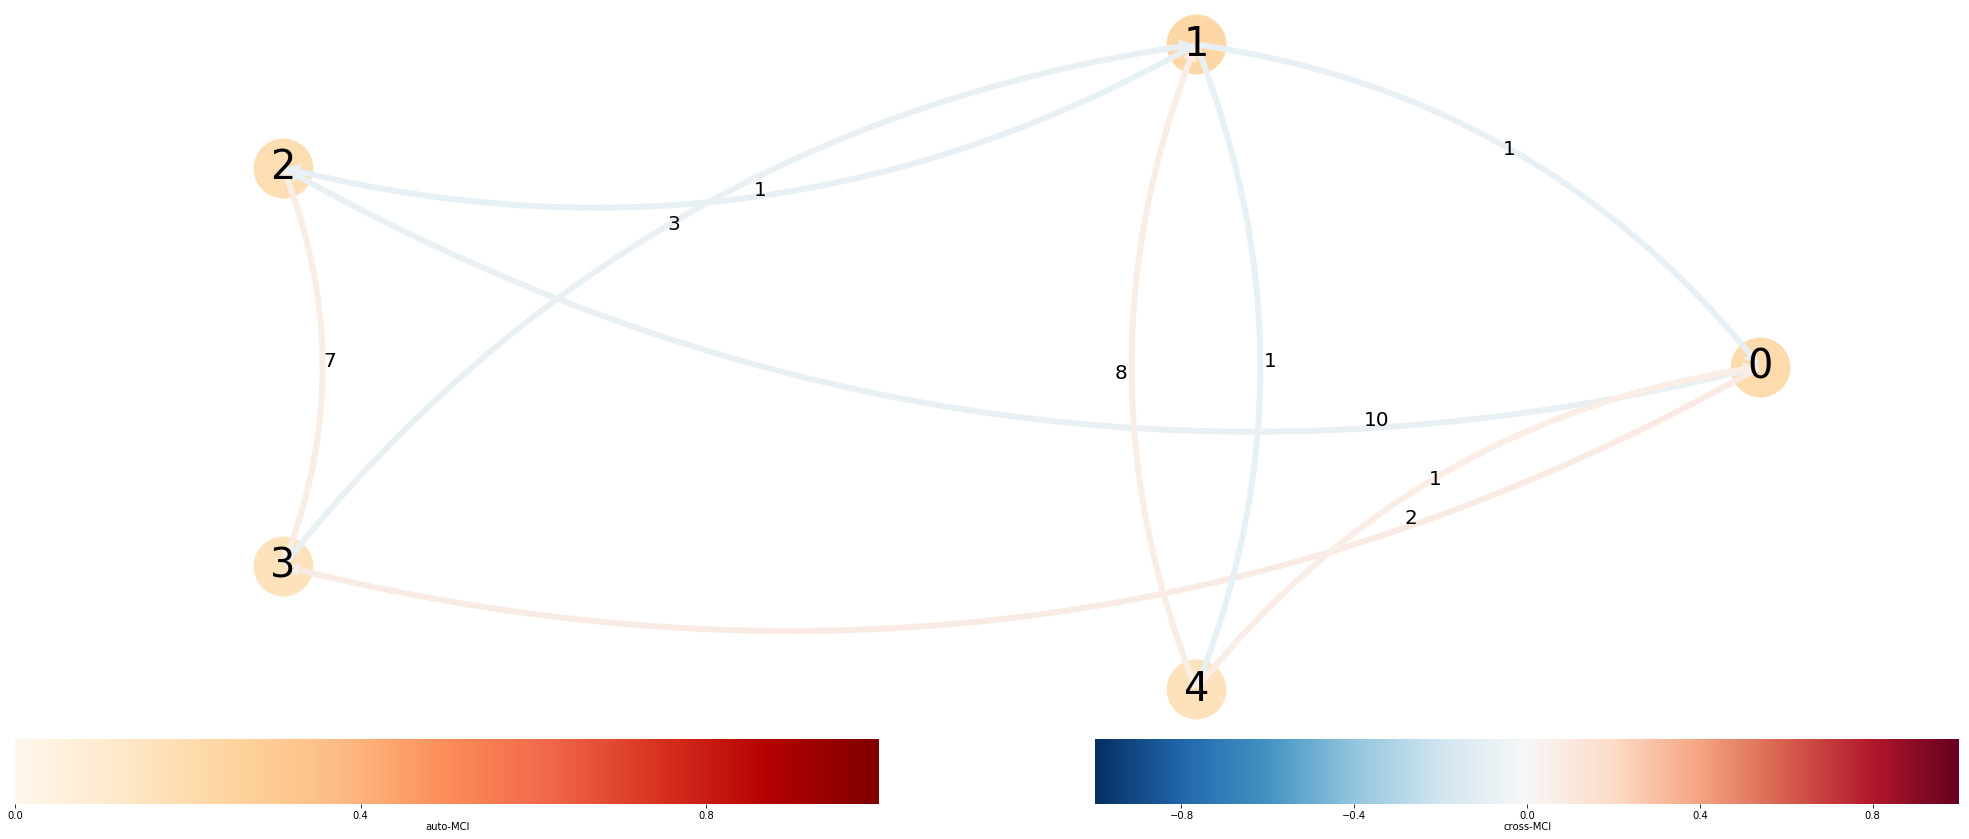

In [12]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60,
    arrow_linewidth = 80
    )

In [13]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.208
        (1 -1): pval = 0.00156 | qval = 0.04823 | val = -0.083
        (0 -9): pval = 0.00167 | qval = 0.04823 | val = 0.082

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.229
        (1 -12): pval = 0.00048 | qval = 0.02044 | val = -0.092

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.190
        (1 -1): pval = 0.00179 | qval = 0.04823 | val = -0.082

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.161
        (3 -3): pval = 0.00018 | qval = 0.00914 | val = 0.098
        (0 -2): pval = 0.00123 | qval = 0.04629 | val = 0.085

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.165
        (1 -1): pval = 0.00193 | qval = 0.04823 | val = -0.081


(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f721ea19ba8>)

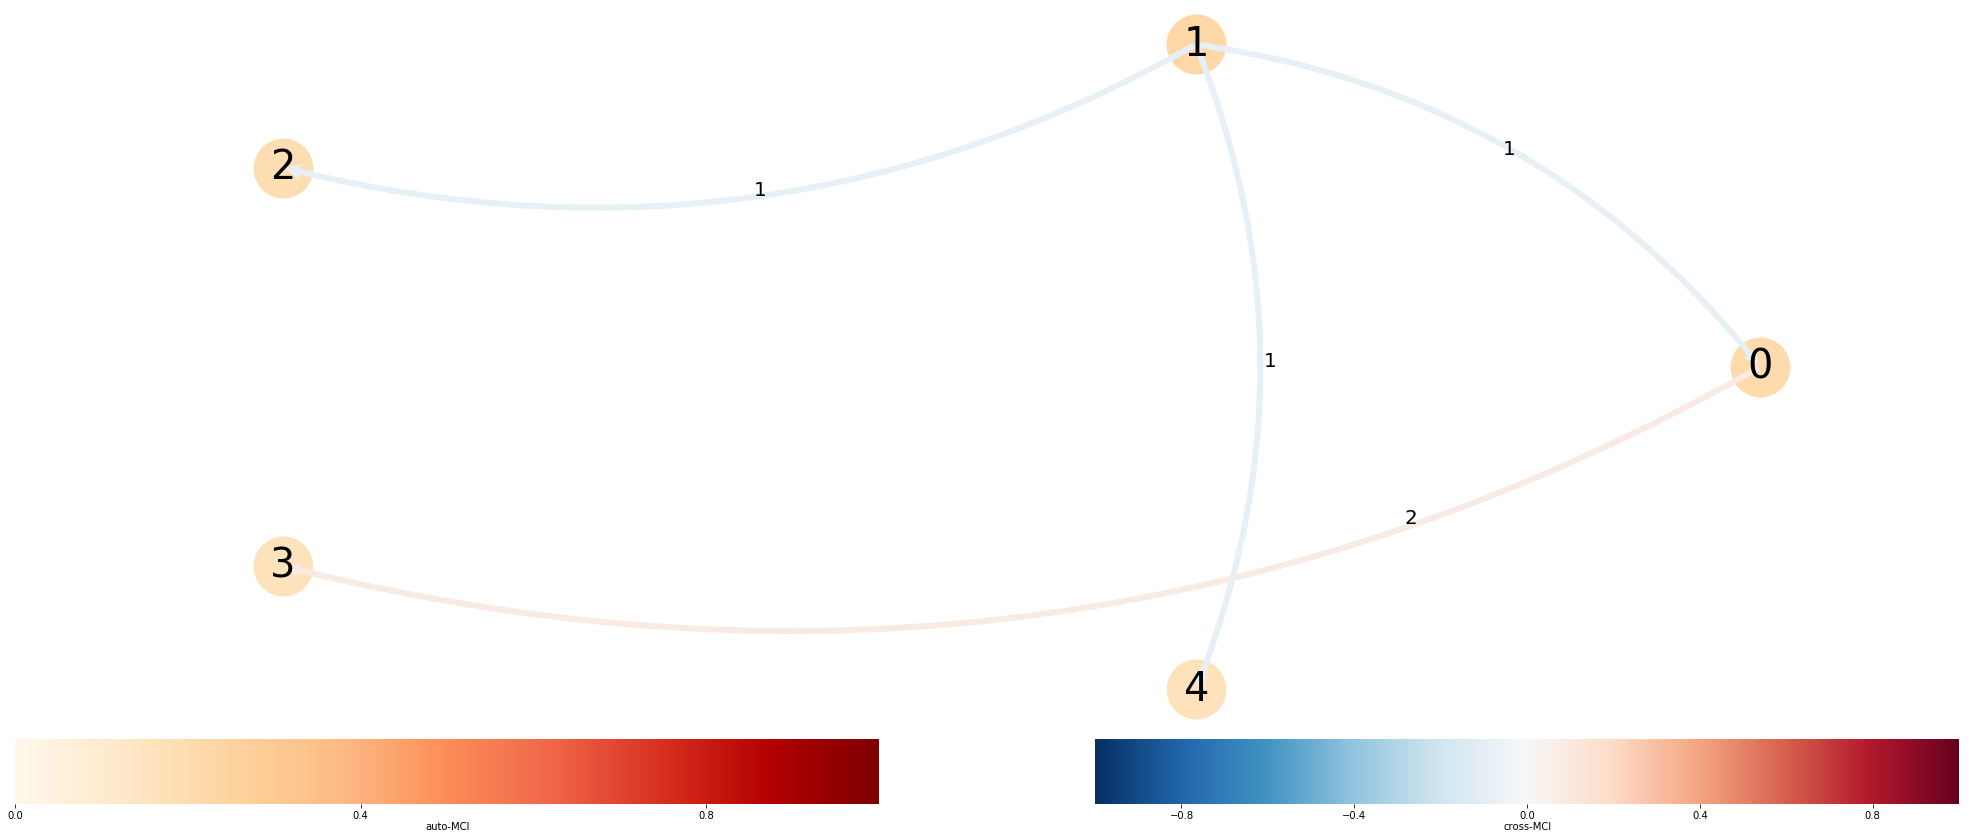

In [14]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

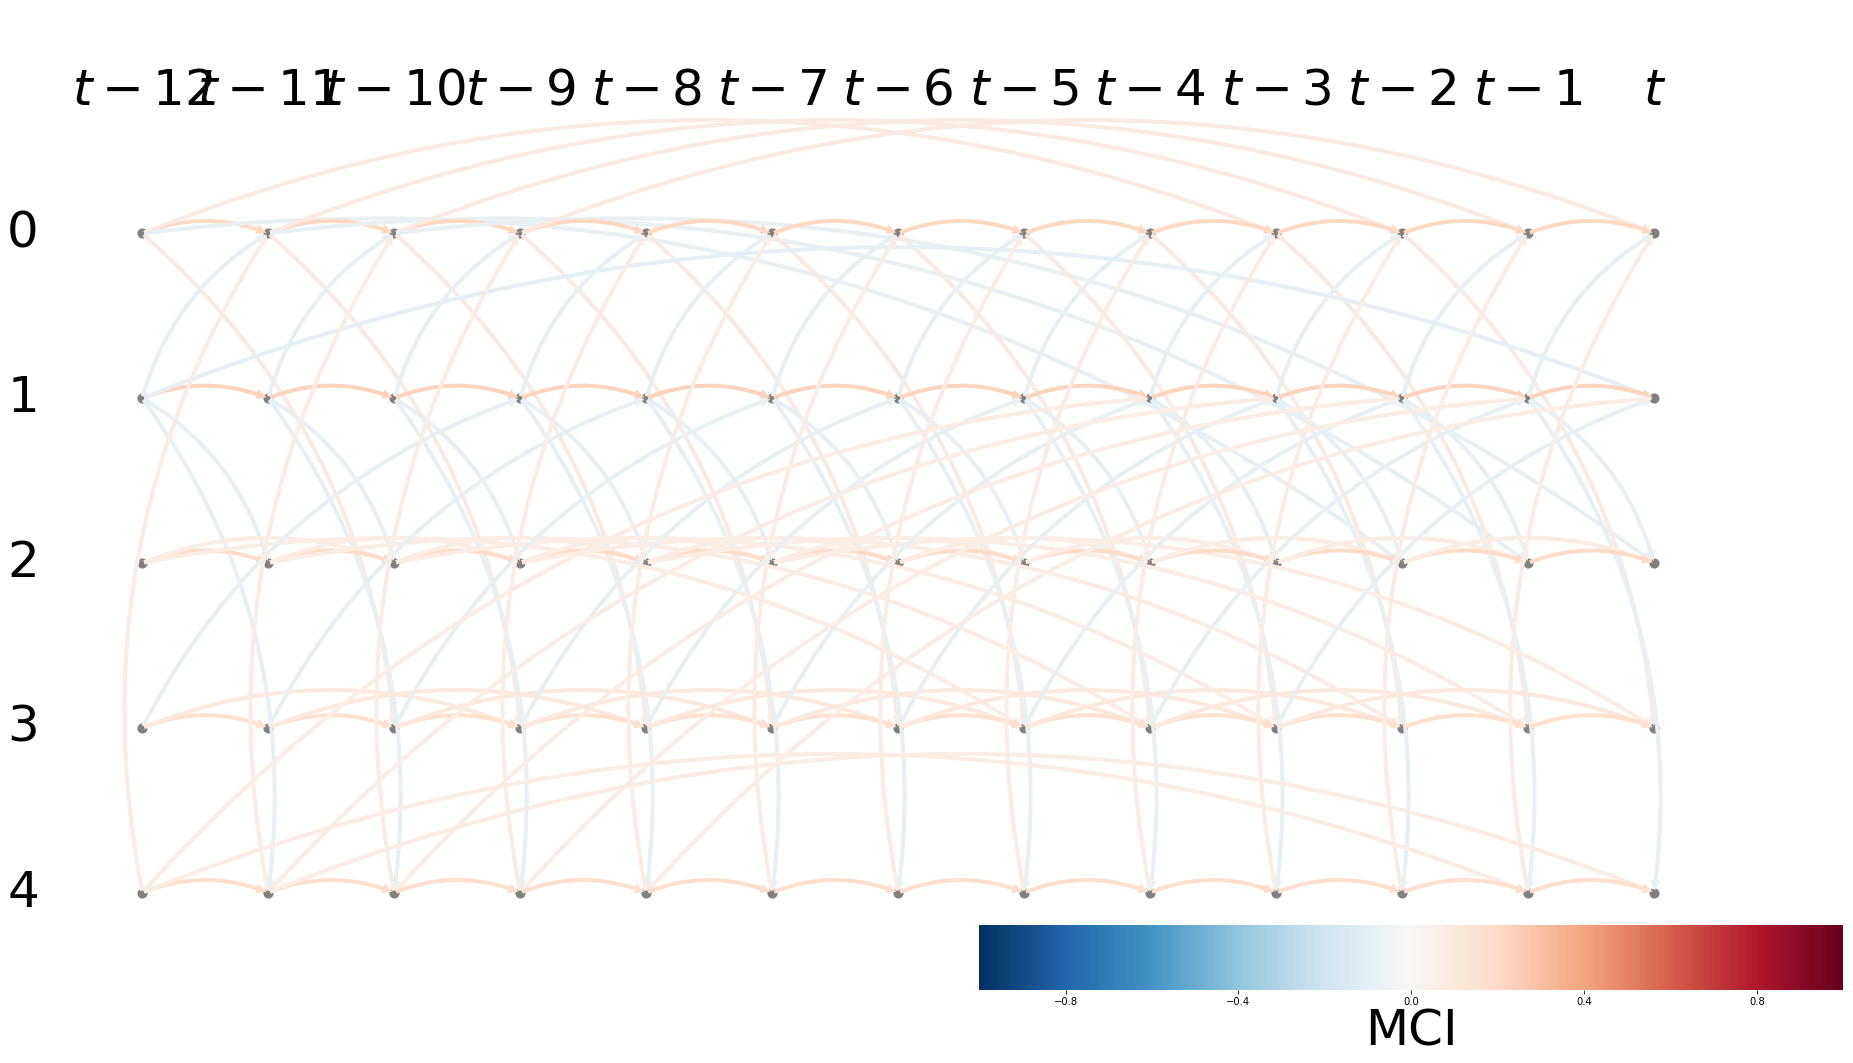

In [18]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

In [15]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5)
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)


##
## Running Tigramite PC algorithm
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = 0.05
max_conds_dim = None
max_combinations = 1



## Variable 0

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (0 -1) --> 0 (1/10):
    Combination 0:  --> pval = 0.00000 / val = 0.032
    No conditions of dimension 0 left.

    Link (0 -2) --> 0 (2/10):
    Combination 0:  --> pval = 0.00200 / val = 0.016
    No conditions of dimension 0 left.

    Link (1 -1) --> 0 (3/10):
    Combination 0:  --> pval = 0.02300 / val = 0.006
    No conditions of dimension 0 left.

    Link (1 -2) --> 0 (4/10):
    Combination 0:  --> pval = 0.32300 / val = 0.001
    Non-significance detected.

    Link (2 -1) --> 0 (5/10):
    Combination 0:  --> pval = 0.00800 / val = 0.007
    No conditions of dimension 0 left.

    Link (2 -2) --> 0 (6/10):
    Combination 0:  --> pval = 0.06000 / val = 0.004
    Non-significance det

KeyboardInterrupt: 

In [1]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

NameError: name 'pcmci' is not defined

In [5]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

NameError: name 'X' is not defined

# All World

In [ ]:
def aggregation(d,level):
    r = []
    for z in range(0,len(d)-level,level):
        r.append(np.nansum(d[range(z,z+level)]))
    return(np.array(r))

In [24]:
f_pre = Dataset('world_precipitation.nc')

In [87]:
f_pre = Dataset('precipitation_daily.nc')
data = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
time = f_pre.variables['time'][:]
data = np.swapaxes(data,0,2)

In [88]:
n_components = 5
level = 365

In [89]:
result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        #if not np.isnan(data[i,j,-1]):
        if not data[i,j,-1]<0:    
            result.append(data[i,j,:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [90]:
result = pf.deseasonalize(np.transpose(np.array(result)), freq=level)

In [ ]:
result = np.load("daily_data.npy")

In [110]:
result = np.load("monthly_data.npy")

In [101]:
result = np.load("weekly_data.npy")

In [111]:
result = np.nan_to_num(result)

In [112]:
data = pd.DataFrame(result)

In [113]:
n_components = 5

#result = np.matrix(result)
#result = result.transpose()
#result = pf.deseasonalize(np.transpose(np.array(result)))
#data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


#loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
loading = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [41]:
pc = 0
df["pc"] = loading[pc]

In [42]:
#lon1 = np.arange(-178.75,179.0,2.5)
lon1 = np.arange(-29.75,59.75,0.5)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon1[j])].clusters.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon1[j])].pc.values
        else:
            deg[i,j]=np.nan

In [152]:
#deg = np.flip(deg, axis=0)

Text(0.5,1,'PC 0')

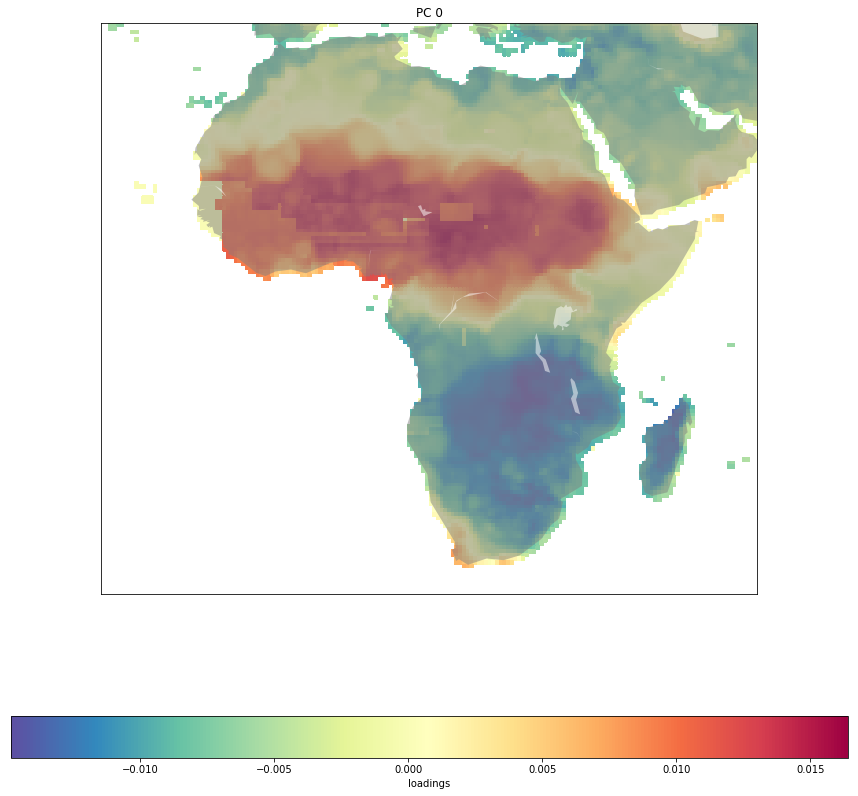

In [43]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('loadings')
plt.title("PC %d"%(pc))

Text(0.5,1,'PC 4')

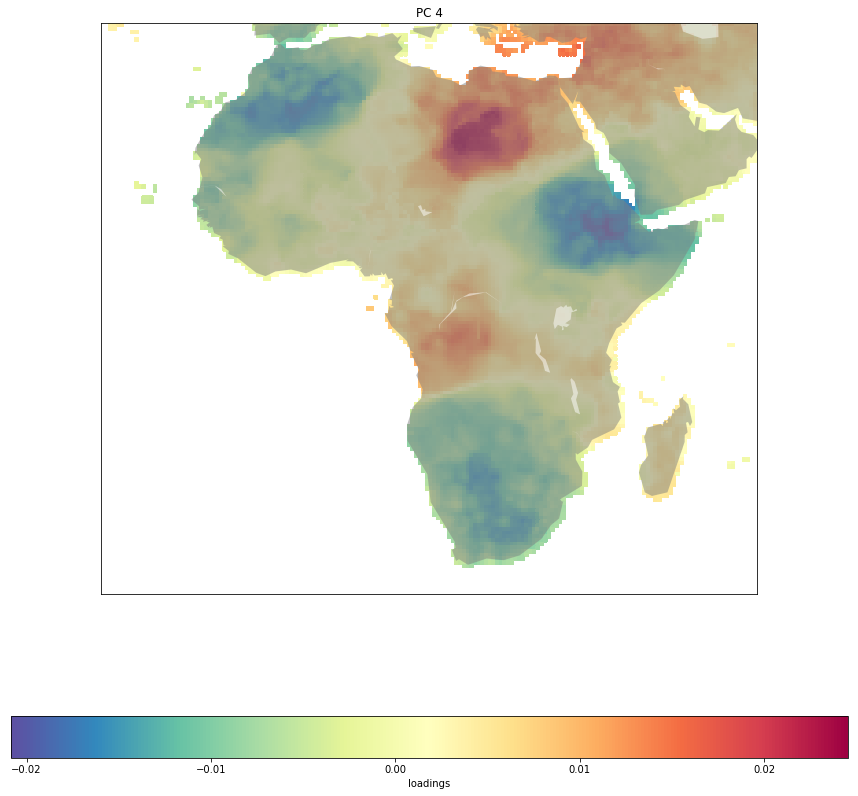

In [20]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('loadings')
plt.title("PC %d"%(pc))

Text(0.5,1,'PC 4')

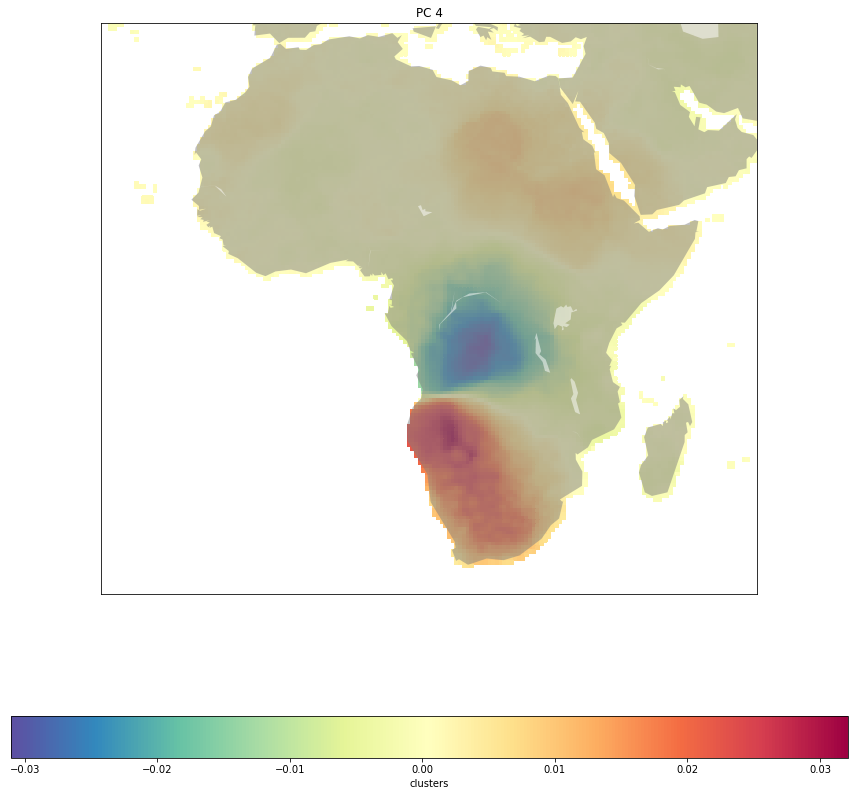

In [33]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('clusters')
plt.title("PC %d"%(pc))

In [114]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [115]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (3 -2): pval = 0.00259 | val = 0.137
        (1 -2): pval = 0.01962 | val = 0.107
        (3 0): pval = 0.02725 | val = 0.101

    Variable 1 has 2 link(s):
        (3 -2): pval = 0.00032 | val = 0.164
        (2 -2): pval = 0.00091 | val = 0.151

    Variable 2 has 0 link(s):

    Variable 3 has 1 link(s):
        (0 0): pval = 0.02725 | val = 0.101

    Variable 4 has 0 link(s):


In [116]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 0 link(s):

    Variable 1 has 0 link(s):

    Variable 2 has 0 link(s):

    Variable 3 has 0 link(s):

    Variable 4 has 0 link(s):


(<Figure size 2160x1080 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ff9b599b0>)

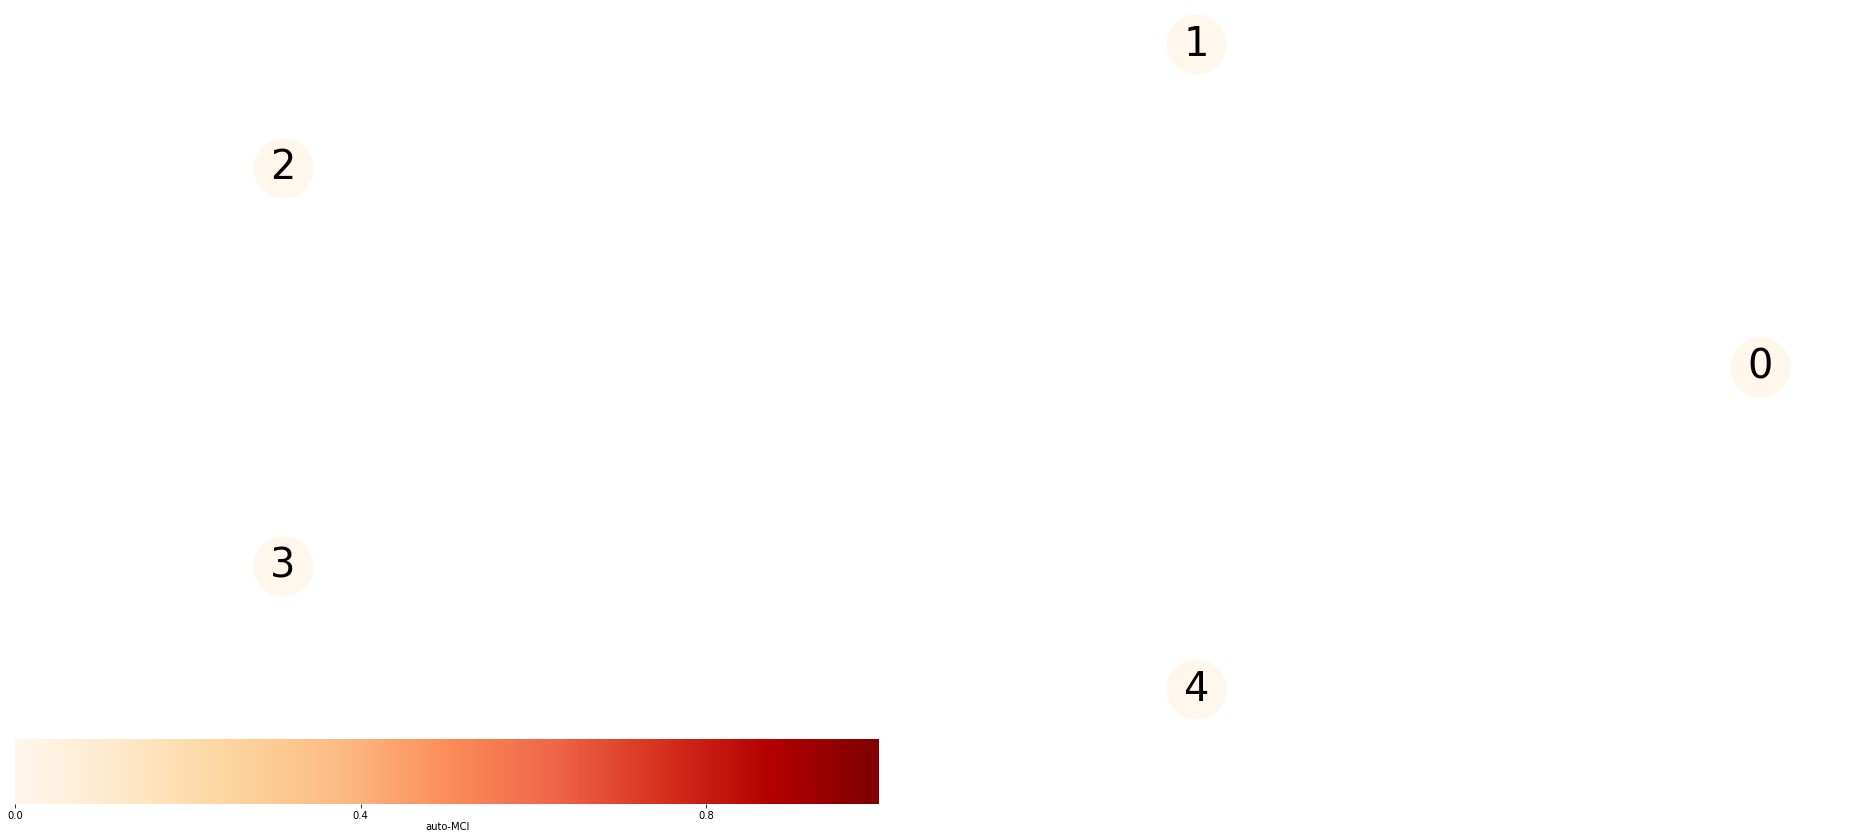

In [117]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

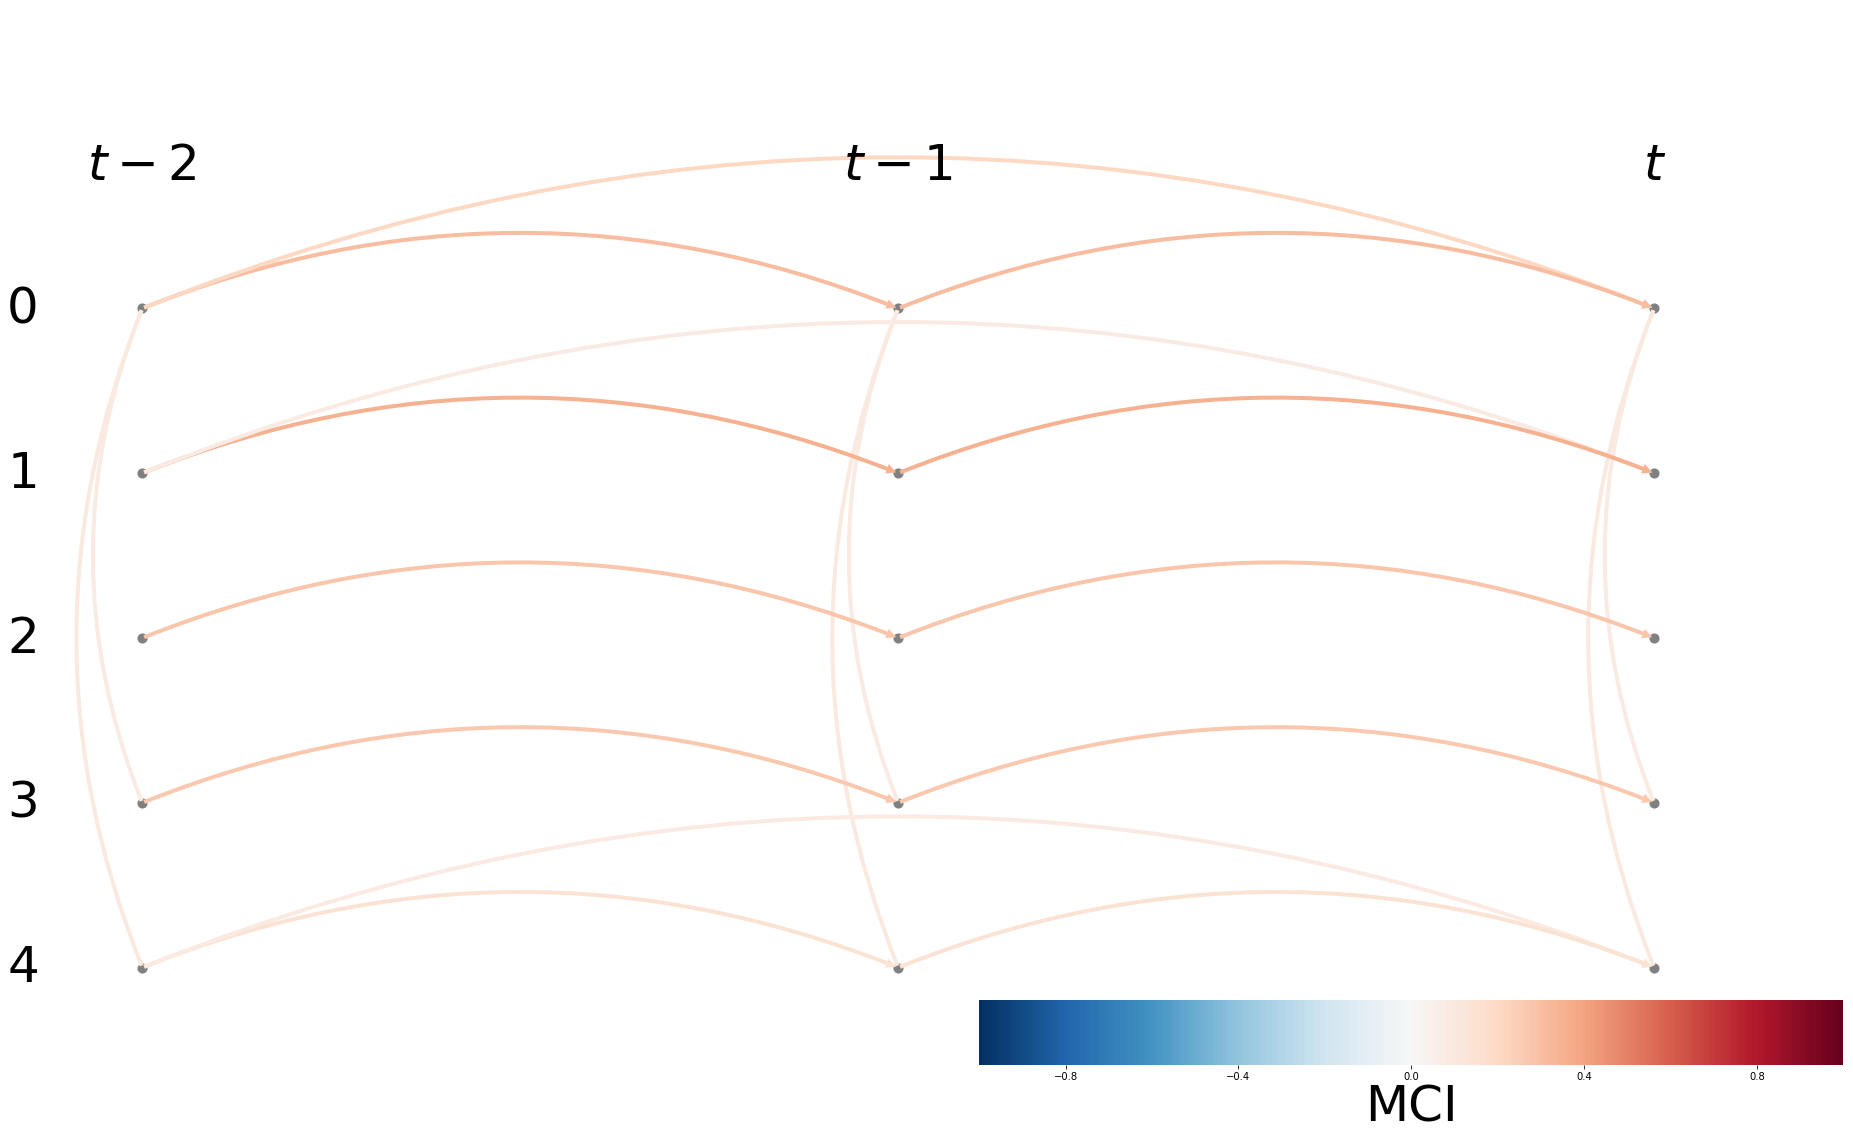

In [109]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

Text(0.5,1,'PC 0')

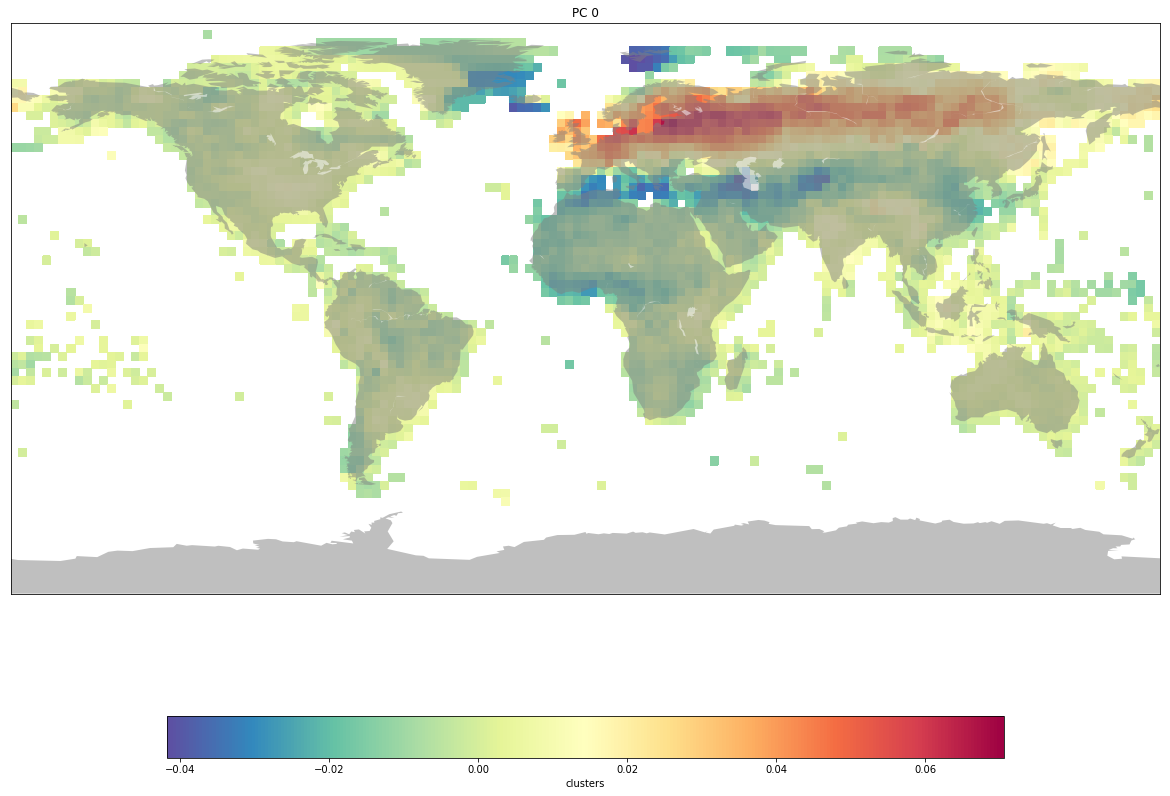

In [40]:
#lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
map.drawcoastlines(linewidth=0.)
xx, yy = meshgrid(lon1, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
#plt.clim(-0.1,0.1)
cbar.set_label('clusters')
plt.title("PC %d"%(pc))

# Air Pressure

In [5]:
f_sat = Dataset('pres.mon.mean.nc')

data_sat = f_sat.variables['pres']
lon_sat = f_sat.variables['lon'][:]
lat_sat = f_sat.variables['lat'][:]
time_sat = f_sat.variables['time'][:]
data_sat = np.swapaxes(data_sat,0,2)

In [42]:
result_sat = []
index = []
lat_sat_list = []
lon_sat_list =[]

for i in range(data_sat.shape[0]):
    for j in range(data_sat.shape[1]):
        if not data_sat[i,j,-1]<-9.9e+36:
            result_sat.append(data_sat[i,j,:-44])
            #result_sat.append(data_sat[i,j,:])
            index.append((lon_sat[i],lat_sat[j]))
            lon_sat_list.append(lon_sat[i])
            lat_sat_list.append(lat_sat[j])

In [43]:
result_sat = pf.deseasonalize(np.transpose(np.array(result_sat)))
n_components_sat = 10

#result_sat = np.matrix(result_sat)
#result_sat = result_sat.transpose()
data = pd.DataFrame(result_sat)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components_sat)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading_sat = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading_sat.idxmax(axis=1)
df_sat = pd.DataFrame({"lons":lon_sat_list,"lats":lat_sat_list,"clusters":clusters.values.tolist()})

lon_temp = df_sat["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sat["lons"].vlues = lon_temp

# Precipitation for World

In [45]:
f_pre = Dataset('world_precipitation.nc')
data = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
data = np.swapaxes(data,0,2)
#data = np.load("spi1_world.npy")

In [46]:
result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not data[i,j,-1]<0:
            result.append(data[i,j,684:-12])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [47]:
result = pf.deseasonalize(np.transpose(np.array(result)))
n_components = 10

#result = np.matrix(result)
#result = result.transpose()
data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

In [48]:
pres_name  = []
for i in range(n_components_sat):
    pres_name.append("SAT_%d"%i)

pre_name  = []
for i in range(n_components):
    pre_name.append("PRE_%d"%i)

var_names = pre_name + pres_name

result = result.dot(loading)
result_sat = result_sat.dot(loading_sat)

result_all = np.concatenate((result, result_sat), axis=1)

In [49]:
result = np.matrix(result_all)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [50]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable PRE_0 has 16 link(s):
        (SAT_1 0): pval = 0.00001 | val = 0.166
        (PRE_6 0): pval = 0.00002 | val = 0.158
        (SAT_6 0): pval = 0.00021 | val = 0.137
        (PRE_4 0): pval = 0.00037 | val = 0.131
        (PRE_4 -1): pval = 0.00046 | val = -0.129
        (PRE_0 -1): pval = 0.00053 | val = 0.128
        (SAT_9 0): pval = 0.00097 | val = 0.122
        (SAT_7 0): pval = 0.00197 | val = -0.115
        (PRE_3 0): pval = 0.00258 | val = -0.112
        (SAT_9 -5): pval = 0.00275 | val = -0.111
        (SAT_5 -1): pval = 0.00510 | val = -0.103
        (PRE_8 -12): pval = 0.00548 | val = 0.102
        (PRE_9 0): pval = 0.01742 | val = -0.089
        (SAT_3 -8): pval = 0.01931 | val = -0.087
        (PRE_0 -8): pval = 0.02218 | val = 0.085
        (SAT_0 -11): pval = 0.04132 | val = -0.075

    Variable PRE_1 has 25 link(s):
        (PRE_1 -1): pval = 0.00000 | val = 0.239
        (SAT_3 -1): pval = 0.00003 | val = 0.155
     

In [55]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable PRE_0 has 7 link(s):
        (SAT_1 0): pval = 0.00001 | qval = 0.00001 | val = 0.166
        (PRE_6 0): pval = 0.00002 | qval = 0.00002 | val = 0.158
        (SAT_6 0): pval = 0.00021 | qval = 0.00021 | val = 0.137
        (PRE_4 0): pval = 0.00037 | qval = 0.00037 | val = 0.131
        (SAT_9 0): pval = 0.00097 | qval = 0.00097 | val = 0.122
        (SAT_7 0): pval = 0.00197 | qval = 0.00197 | val = -0.115
        (PRE_3 0): pval = 0.00258 | qval = 0.00258 | val = -0.112

    Variable PRE_1 has 7 link(s):
        (PRE_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.239
        (SAT_3 -1): pval = 0.00003 | qval = 0.00828 | val = 0.155
        (SAT_3 0): pval = 0.00069 | qval = 0.00069 | val = 0.125
        (SAT_2 0): pval = 0.00073 | qval = 0.00073 | val = -0.125
        (SAT_7 0): pval = 0.00135 | qval = 0.00135 | val = 0.119
        (SAT_4 0): pval = 0.00732 | qval = 0.00732 | val = 0.099
        (PRE_8 0): pval = 0.00798 | qval 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0eba4c3828>)

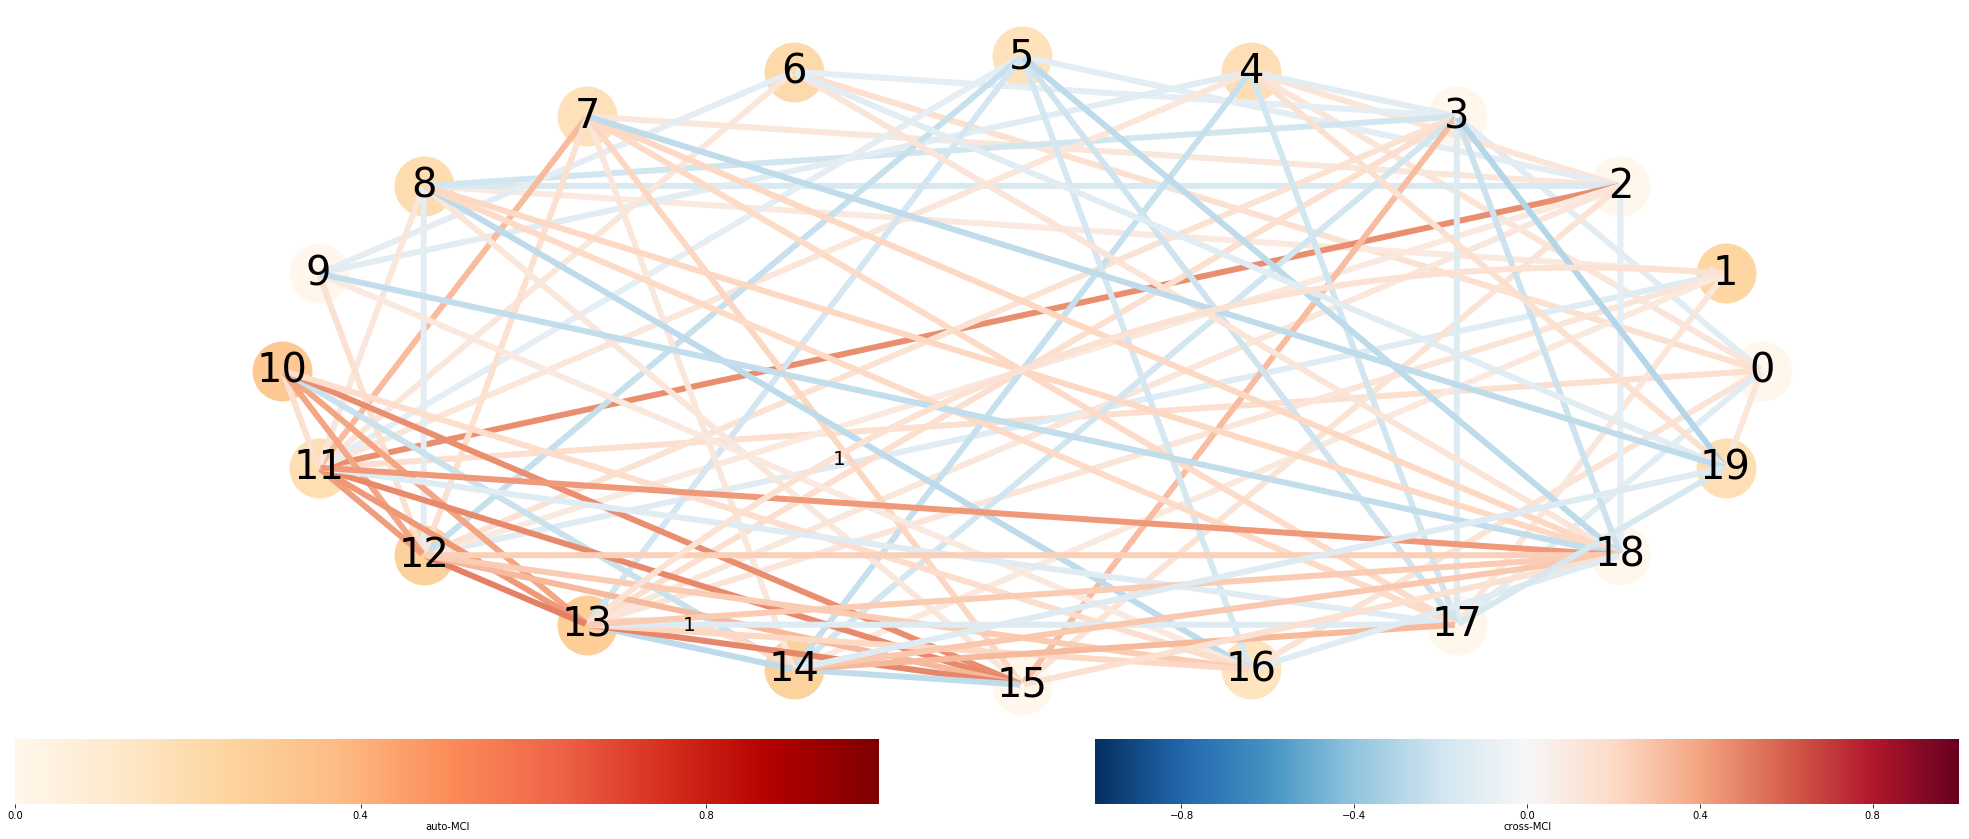

In [56]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

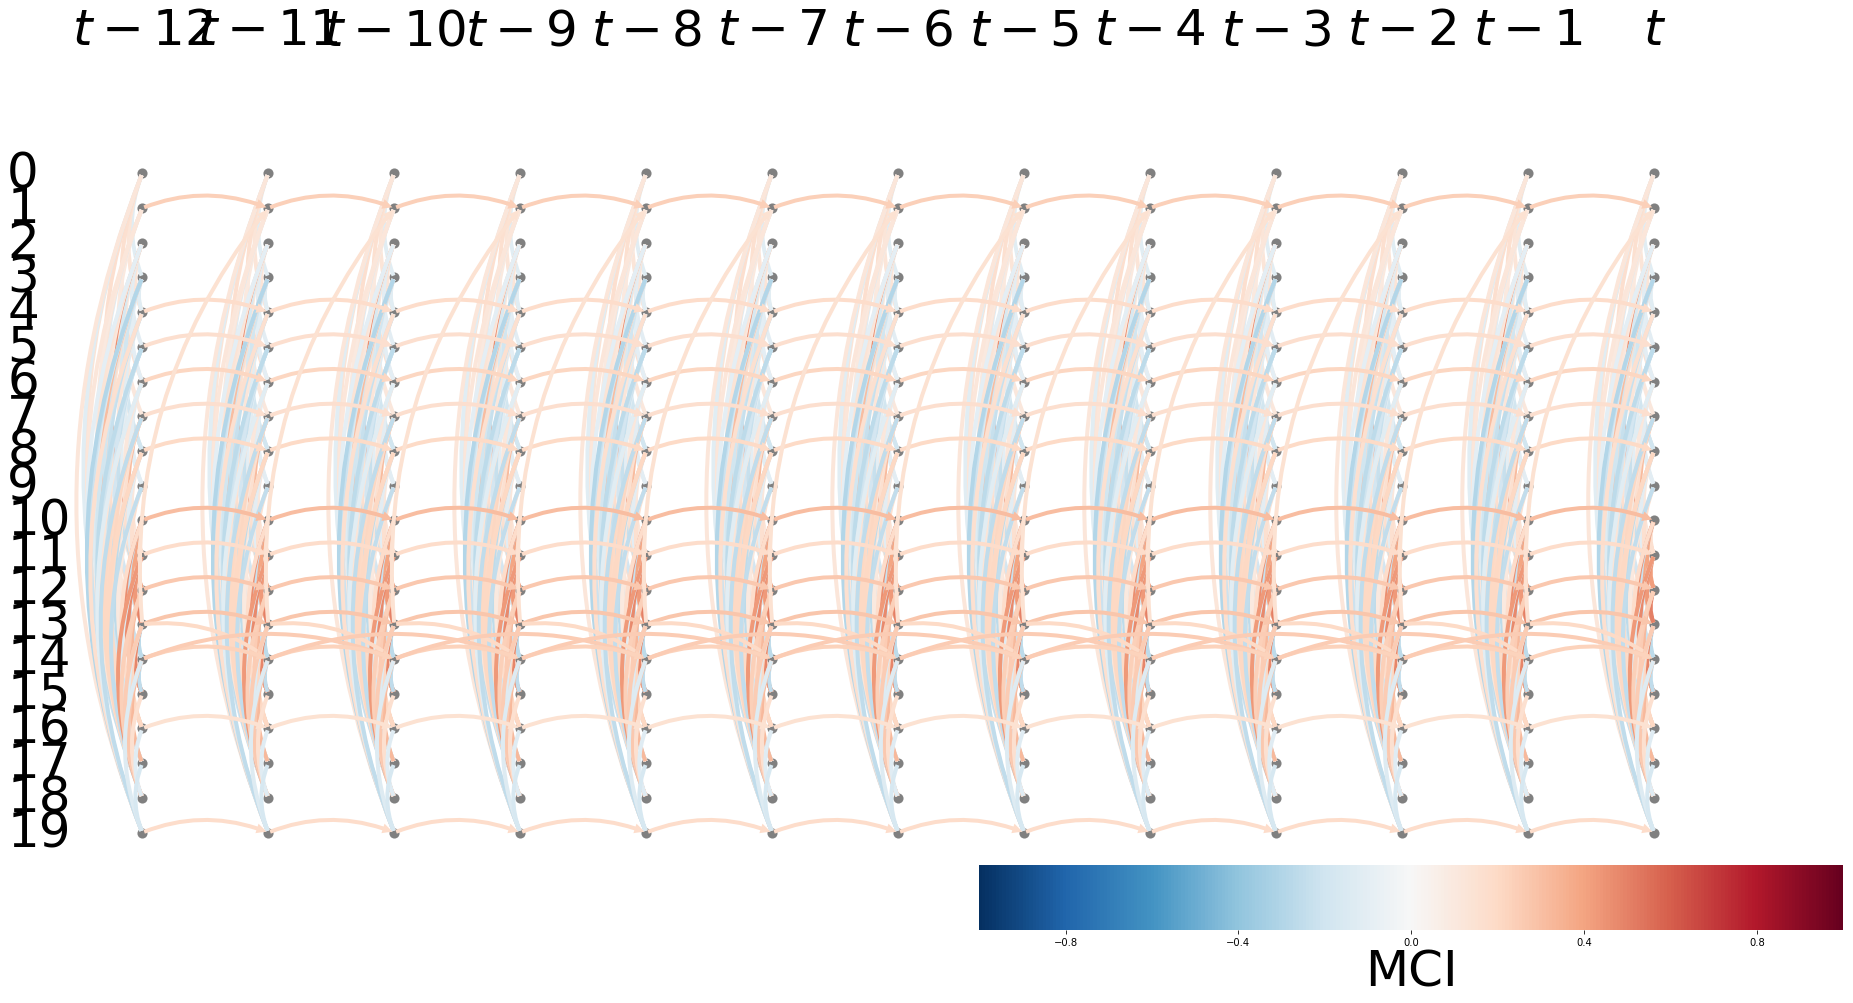

In [54]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

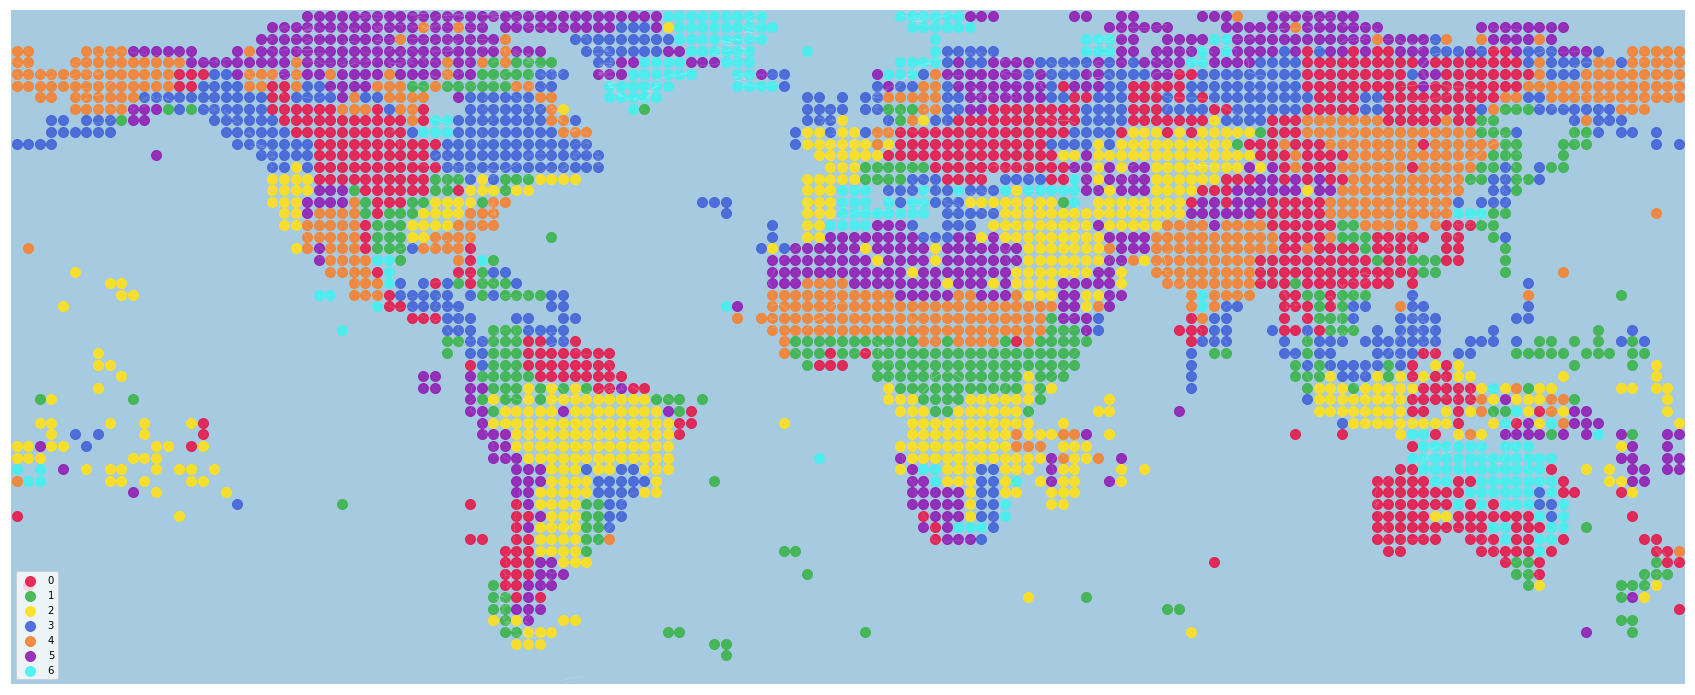

In [7]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']


for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i, c = colors[i])

    
plt.legend()
plt.show()

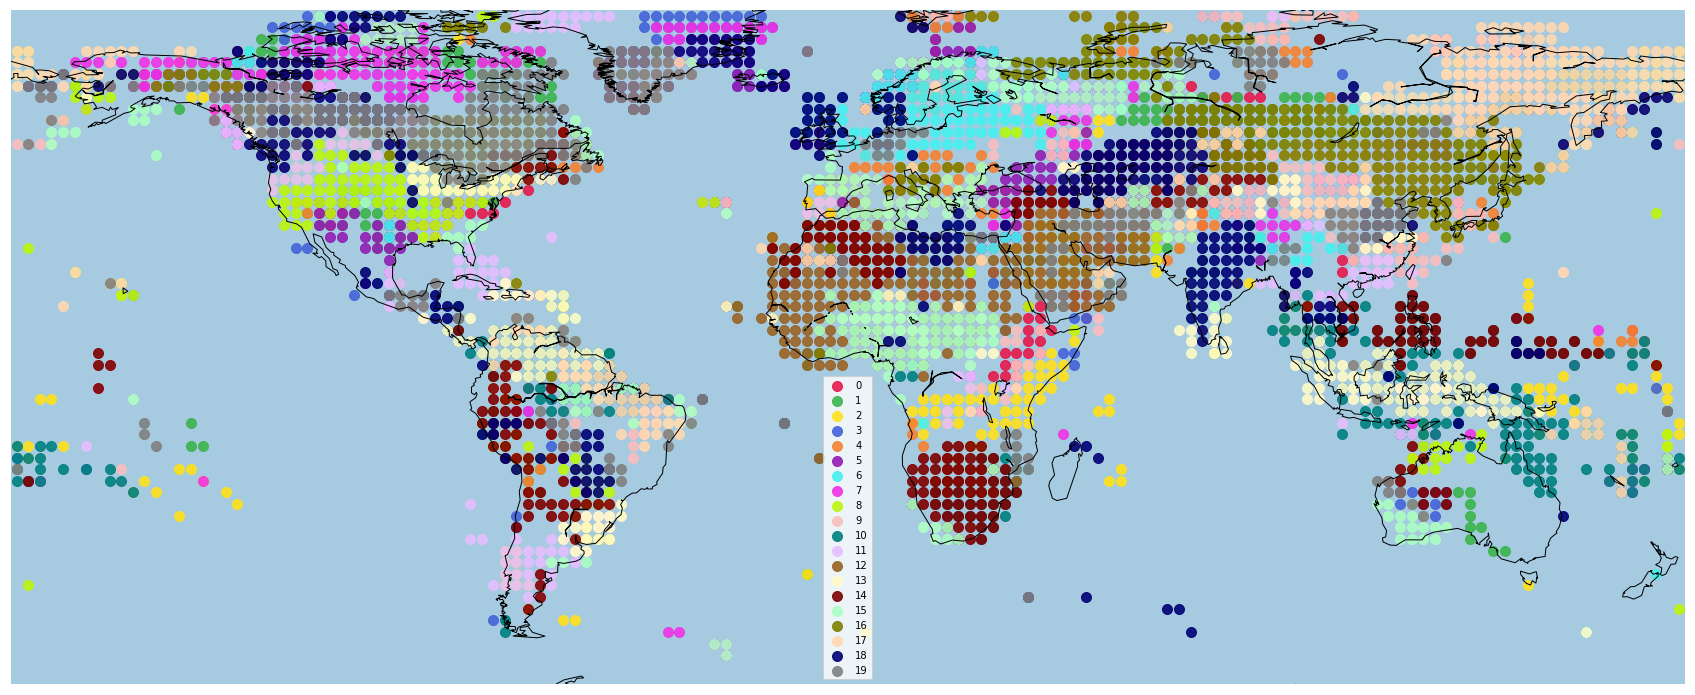

In [48]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=1, color="black")

limit = 0.9

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i, c = colors[i])

    
plt.legend()
plt.show()

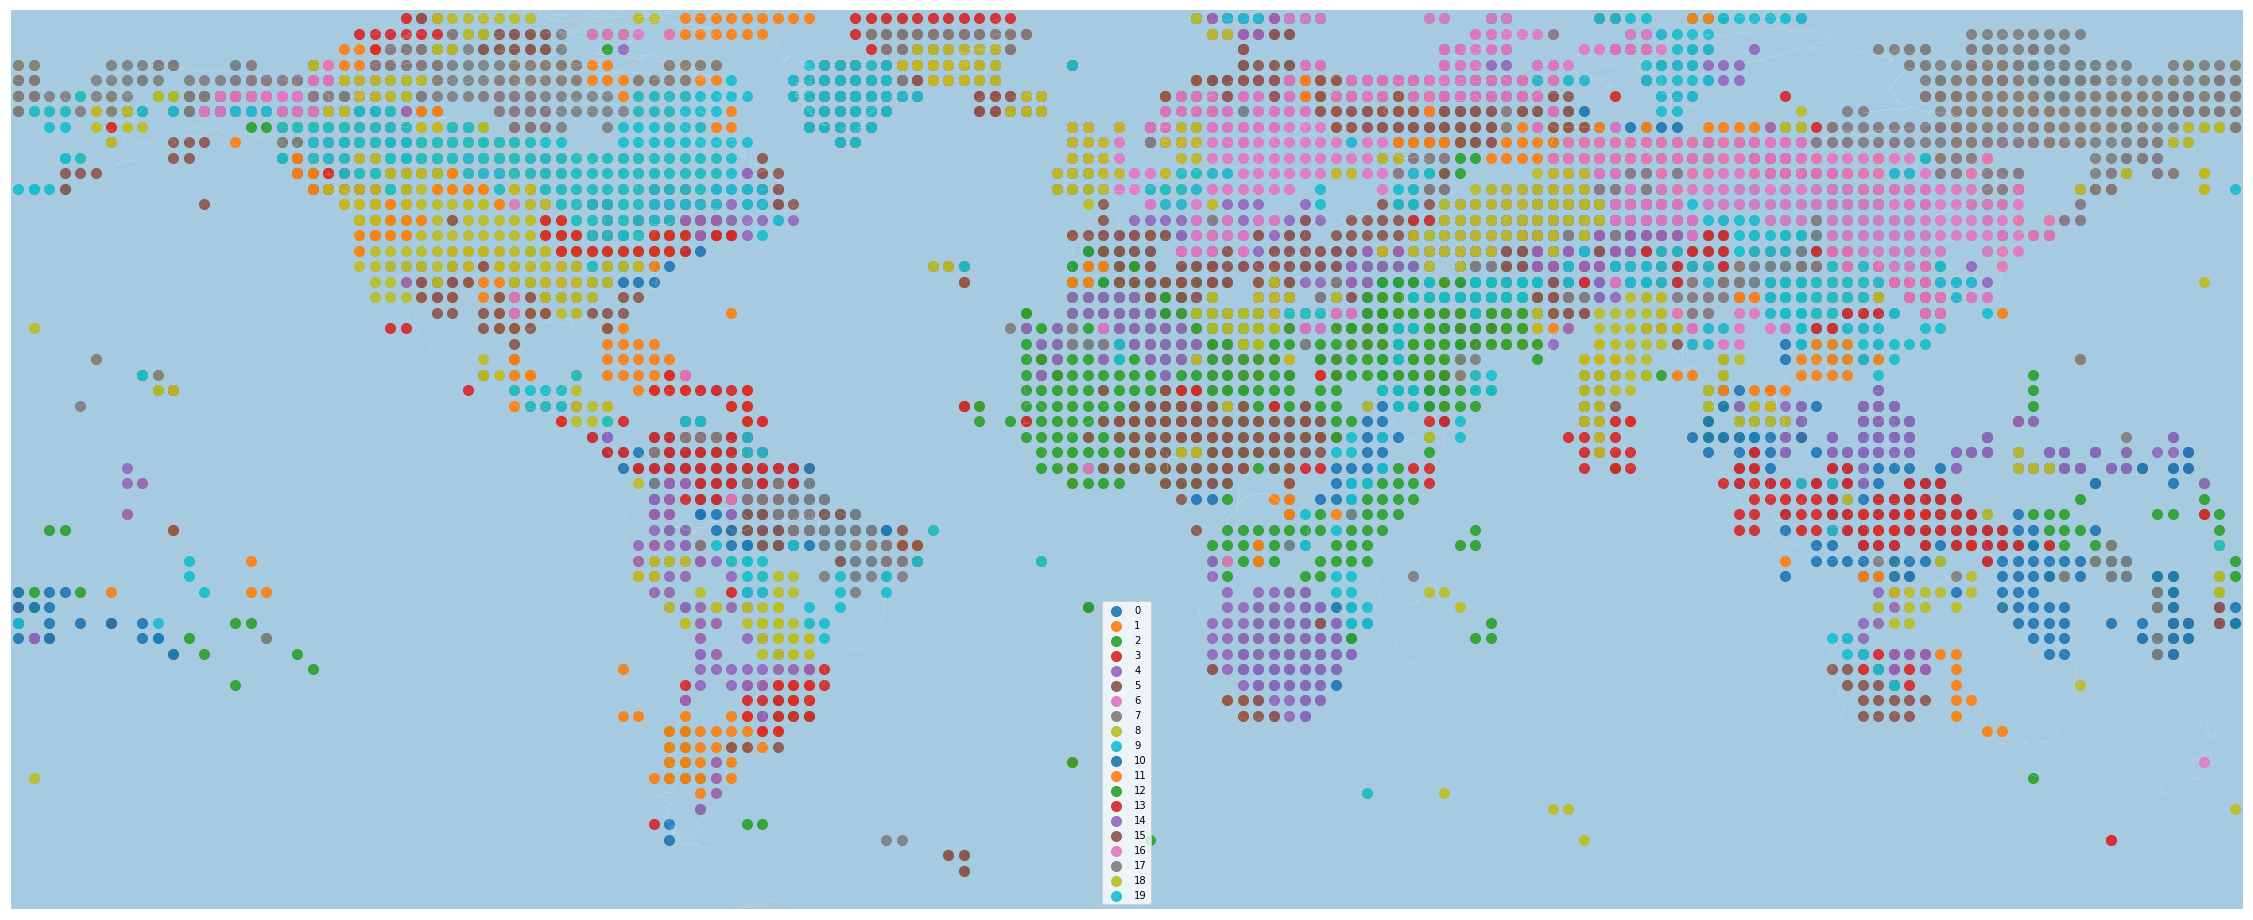

In [49]:
limit = 0.99

df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

limit = 0.9

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()
#plt.savefig("world_clusters.png")

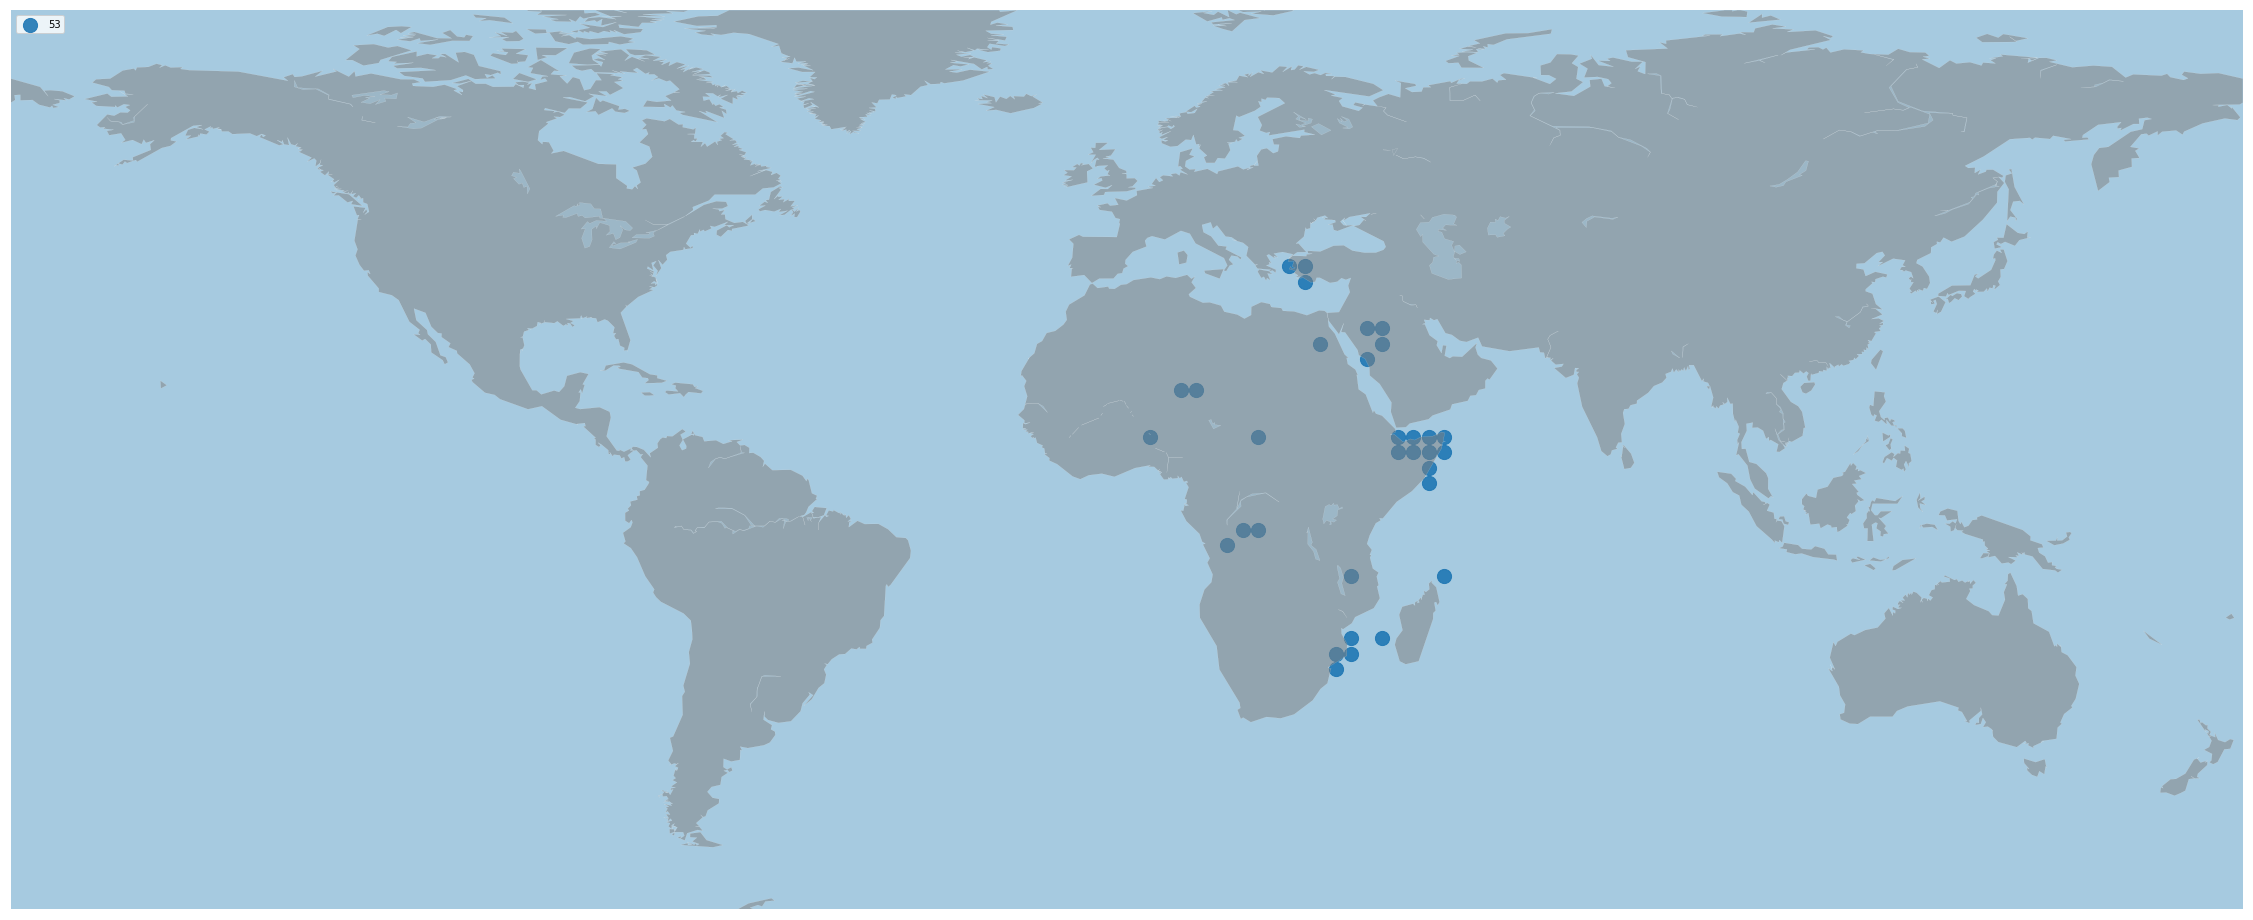

In [13]:
limit = 0.95

i = 53
df1 = pd.DataFrame(columns=df.columns)

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
df1 = df.iloc[Idx,:]
df1["values"] = values

lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [8]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

In [9]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 22 link(s):
        (0 -1): pval = 0.00000 | val = 0.221
        (2 0): pval = 0.00000 | val = -0.215
        (1 0): pval = 0.00000 | val = -0.162
        (5 0): pval = 0.00000 | val = -0.160
        (4 -10): pval = 0.00000 | val = 0.123
        (1 -5): pval = 0.00001 | val = -0.118
        (5 -3): pval = 0.00005 | val = -0.106
        (4 0): pval = 0.00010 | val = -0.102
        (0 -12): pval = 0.00066 | val = 0.090
        (3 -4): pval = 0.00110 | val = -0.086
        (4 -8): pval = 0.00166 | val = -0.083
        (2 -7): pval = 0.00256 | val = 0.079
        (4 -4): pval = 0.00308 | val = -0.078
        (1 -6): pval = 0.00399 | val = -0.076
        (3 0): pval = 0.00531 | val = 0.073
        (2 -2): pval = 0.00538 | val = 0.073
        (6 0): pval = 0.01122 | val = 0.066
        (5 -8): pval = 0.01220 | val = 0.066
        (3 -12): pval = 0.01596 | val = 0.063
        (3 -5): pval = 0.02606 | val = -0.058
        (4 -9): pval 

In [15]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 10 link(s):
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.221
        (2 0): pval = 0.00000 | qval = 0.00000 | val = -0.215
        (1 0): pval = 0.00000 | qval = 0.00000 | val = -0.162
        (5 0): pval = 0.00000 | qval = 0.00000 | val = -0.160
        (4 -10): pval = 0.00000 | qval = 0.00013 | val = 0.123
        (1 -5): pval = 0.00001 | qval = 0.00025 | val = -0.118
        (5 -3): pval = 0.00005 | qval = 0.00151 | val = -0.106
        (4 0): pval = 0.00010 | qval = 0.00010 | val = -0.102
        (0 -12): pval = 0.00066 | qval = 0.00929 | val = 0.090
        (3 0): pval = 0.00531 | qval = 0.00531 | val = 0.073

    Variable 1 has 8 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.252
        (2 0): pval = 0.00000 | qval = 0.00000 | val = 0.193
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.174
        (1 -12): pval = 0.00000 | qval = 0.00000 | val = 0.166
        (0 0): pval = 0.0000

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f259cd41ac8>)

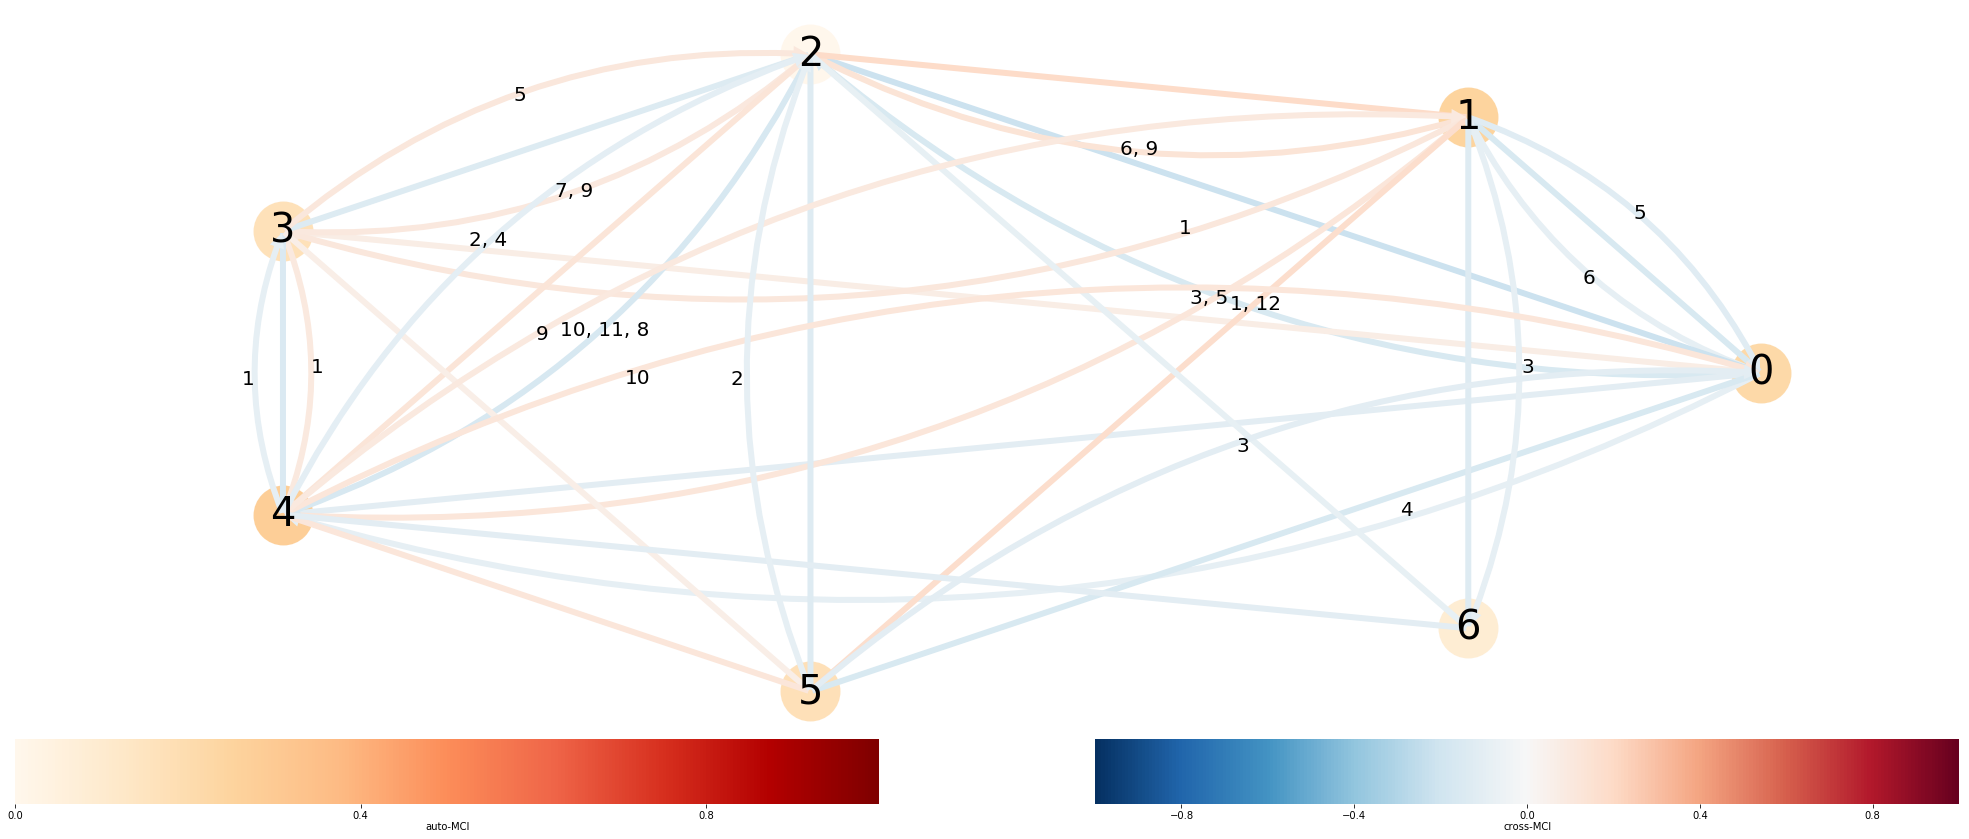

In [16]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

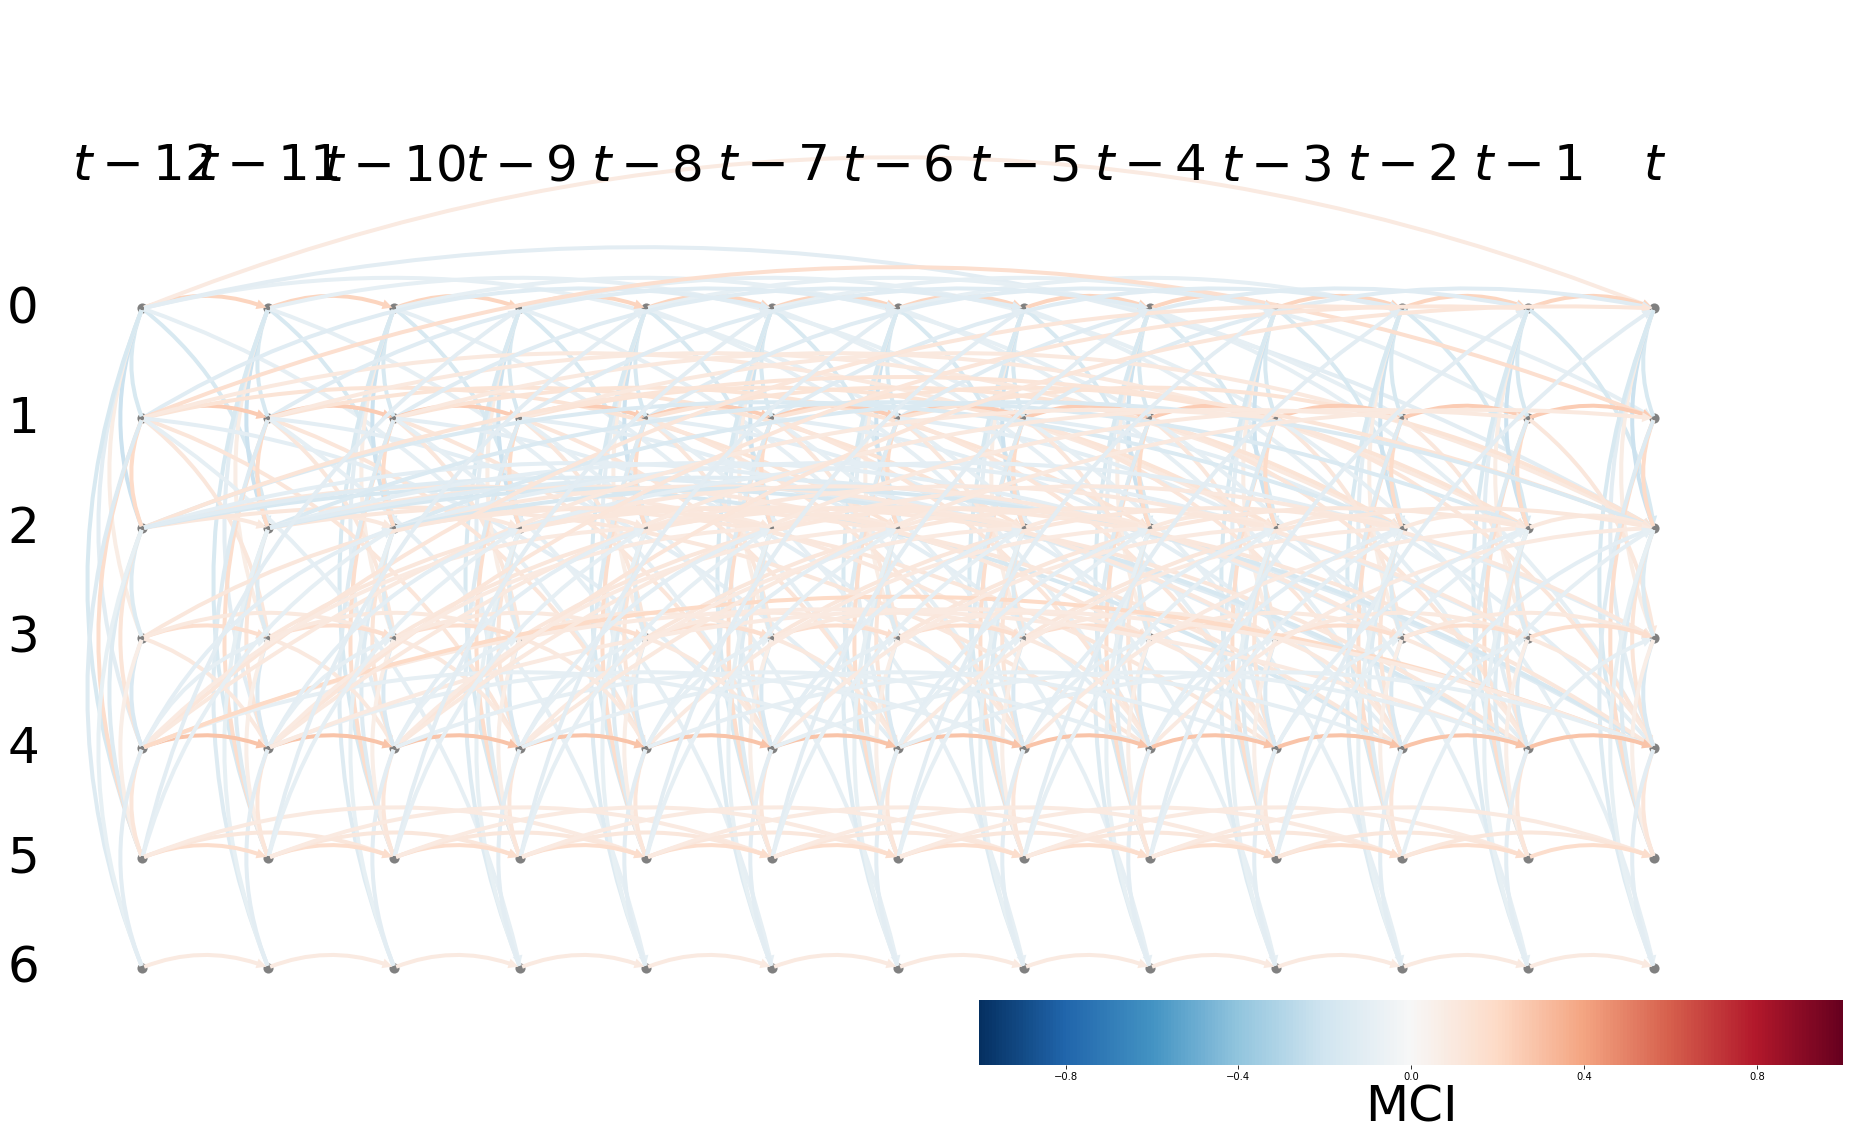

In [17]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )